In [1]:
import glob
pattern = '*.ipynb'
query = 'imshow'

for filepath in glob.iglob(pattern, recursive=True):
    with open(filepath) as file:
        s = file.read()
        if (s.find(query) > -1):
            print(filepath)

00_tcr_stats.ipynb
investigate_cdr3_duplets_across_clonotypes.ipynb


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import re
import statistics

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size, calc_binding_concordance,epitope_sorter_index)

In [3]:
plt.style.use('ggplot')

In [4]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [5]:
def sum_umi_tra(row):
    if len(row.umi_count_lst_TRA) == len(row.cdr3_lst_TRA):
        mat_tra.loc[row.cdr3_lst_TRA, row.gem] = row.umi_count_lst_TRA
    else:
        mat_tra.loc[row.cdr3_lst_TRA, row.gem] = [0] * len(row.cdr3_lst_TRA)
        
def sum_umi_trb(row):
    if len(row.umi_count_lst_TRB) == len(row.cdr3_lst_TRB):
        mat_trb.loc[row.cdr3_lst_TRB, row.gem] = row.umi_count_lst_TRB
    else:
        mat_trb.loc[row.cdr3_lst_TRB, row.gem] = [0] * len(row.cdr3_lst_TRB)

# Input

In [6]:
INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

# Output

In [7]:
OUT_DIR = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9_IONTORRENT_KMA_AKB/post_processing/"

# Load

In [8]:
df = pd.read_csv(INPUT, converters=converters) #

In [9]:
df = calc_binding_concordance(df.copy(),'ct')

### Filtering

In [10]:
filtering = (df.umi_count_TRB >= 0) & (df.delta_umi_TRB >= 2) & (df.umi_count_mhc >= 17) & (df.delta_umi_mhc >= 2)

# Main

In [11]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr3_TRA',
       'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA', 'cdr3_lst_TRA',
       'chain_count_TRA', 'single_TRA', 'length_TRB', 'cdr3_TRB',
       'umi_count_TRB', 'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB',
       'chain_count_TRB', 'single_TRB', 'single_chain_only', 'umi_count_tcr',
       'cdr3_comb', 'tcr_category', 'no_filtration',
       'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'multiplets_mhc', 'delta_umi_mhc',
       'template_id_cd8', 'template_lst_cd8', 'single_barcode_cd8',
       'umi_count_cd8', 'umi_count_lst_cd8', 'read_count_cd8',
       'read_count_lst_cd8', 'detected_response', 'peptide_assayed',
       'sample_id', 'sample_id

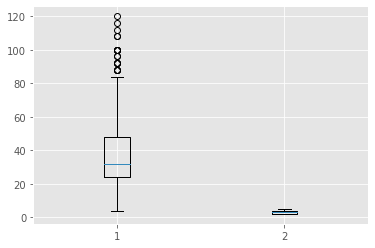

In [12]:
a = df[filtering & (df.chain_count_TRB == 1)].delta_umi_TRB
b = df[filtering & (df.chain_count_TRB > 1)].delta_umi_TRB

plt.boxplot([a,b])
plt.show()

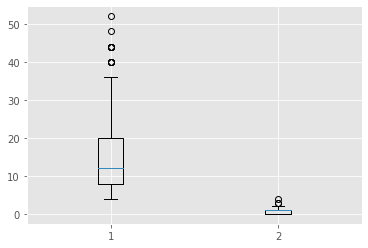

In [13]:
a = df[filtering & (df.chain_count_TRA == 1)].delta_umi_TRA
b = df[filtering & (df.chain_count_TRA > 1)].delta_umi_TRA

plt.boxplot([a,b])
plt.show()

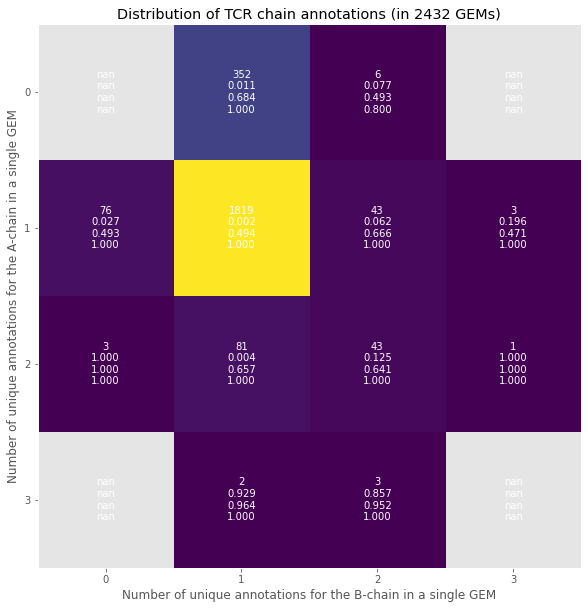

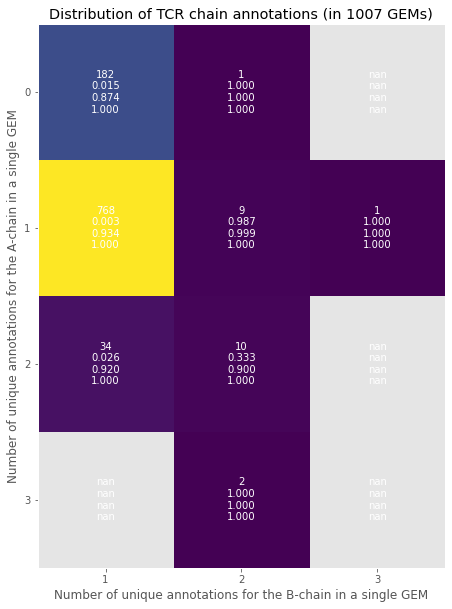

In [14]:
mpl.rcParams['axes.grid'] = False
for tmp, title in [(df, 'all'), (df[filtering], 'flt')]:
    tmp = calc_binding_concordance(tmp.copy(),'ct')
    
    cln_tmp = tmp.gem.to_frame()
    cln_tmp['chain_count_TRA'] = tmp.apply(lambda x: len(x.cdr3_lst_TRA) if x.cdr3_lst_TRA[0] != '' else 0, axis=1)
    cln_tmp['chain_count_TRB'] = tmp.apply(lambda x: len(x.cdr3_lst_TRB) if x.cdr3_lst_TRB[0] != '' else 0, axis=1)
    cln_tmp['conc'] = cln_tmp.gem.map(tmp.set_index('gem').binding_concordance)

    matrix = cln_tmp.fillna(0).groupby(['chain_count_TRA','chain_count_TRB']).gem.size().to_frame().reset_index().pivot(index='chain_count_TRA', columns='chain_count_TRB', values='gem')
    matmin = cln_tmp.fillna(0).groupby(['chain_count_TRA','chain_count_TRB']).conc.min().to_frame().reset_index().pivot(index='chain_count_TRA', columns='chain_count_TRB', values='conc')
    matavg = cln_tmp.fillna(0).groupby(['chain_count_TRA','chain_count_TRB']).conc.mean().to_frame().reset_index().pivot(index='chain_count_TRA', columns='chain_count_TRB', values='conc')
    matmax = cln_tmp.fillna(0).groupby(['chain_count_TRA','chain_count_TRB']).conc.max().to_frame().reset_index().pivot(index='chain_count_TRA', columns='chain_count_TRB', values='conc')
    
    if title == 'all':
        df['chain_count_TRA'] = cln_tmp.chain_count_TRA.values
        df['chain_count_TRB'] = cln_tmp.chain_count_TRB.values
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(matrix, interpolation='nearest')

    # Loop over data dimensions and create text annotations.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, "%.f\n%.3f\n%.3f\n%.3f" %(matrix.iloc[i, j], matmin.iloc[i, j], matavg.iloc[i, j], matmax.iloc[i, j]),
                           ha="center", va="center", color="w")

    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))

    ax.set_xticklabels(matrix.columns.to_list()) #np.arange(0,matrix.shape[1])#+1
    ax.set_yticklabels(matrix.index.to_list()) #np.arange(0,matrix.shape[0])#+1

    # HACK: with matplotlib==3.1.1 the yaxis is cropped..?
    ax.set_ylim(sorted((-0.5, matrix.shape[0]-0.5), reverse=True))

    plt.xlabel('Number of unique annotations for the B-chain in a single GEM')
    plt.ylabel('Number of unique annotations for the A-chain in a single GEM')
    plt.title('Distribution of TCR chain annotations (in %i GEMs)' %matrix.sum().sum())

    plt.savefig(OUT_DIR + 'chain_annotations.%s.pdf' %title, bbox_inches='tight')
    plt.show()

In [15]:
cln_tmp

,gem,chain_count_TRA,chain_count_TRB,conc
0,AAACCTGAGAGGTAGA-1,1,1,0.977346
6,AAACCTGTCGAATCCA-1,1,1,0.977346
7,AAACGGGAGGACATTA-1,2,2,0.666667
11,AAACGGGGTTAGGGTG-1,1,1,0.977346
14,AAAGCAAAGCTCTCGG-1,1,1,1.000000
...,...,...,...,...
2421,TTGCCGTTCCCATTAT-1,0,1,0.916667
2423,TTGCGTCAGAGGTAGA-1,0,1,1.000000
2425,TTGCGTCTCTTATCTG-1,0,1,1.000000
2429,TTTCCTCAGCACGCCT-1,0,1,0.916667


In [16]:
multiplet_TRB_gems = cln_tmp[(cln_tmp.chain_count_TRB > 1) & (cln_tmp.conc < 1)].gem

In [17]:
tmp[tmp.gem.isin(multiplet_TRB_gems)]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr3_TRA,...,likely_HLA_mhc,peptide,peptide_lst,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance
7,AAACGGGAGGACATTA-1,NaN,0.0,39.0,TRAV3;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC' 'TRAV3;TRAJ47;TRAC'],['TRBV27;;TRBJ2-7;TRBC2' 'TRBV7-3;;TRBJ2-1;TRB...,609.0,CAVNYGNKLVF,...,NaN,RAKFKQLL,['TPRVTGGGAM' 'IRHKRQSWV' 'EERQAYLTNQY' 'MDMFS...,RAKFKQLL B0801,"[TPRVTGGGAM B0702, IRHKRQSWV B0801, EERQAYLTNQ...",V17_B8 EBV BZLF1 (C9),['V14_B7 CMV pp65 TPR' '47_1_94' '45_1_3' '...,2,3,0.666667
304,AGCGGTCGTTGGGACA-1,NaN,0.0,39.0,TRAV3;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC' 'TRAV3;TRAJ47;TRAC'],['TRBV27;;TRBJ2-7;TRBC2' 'TRBV7-3;;TRBJ2-1;TRB...,609.0,CAVNYGNKLVF,...,NaN,NLVPMVATV,['FLDTNQVVRIL' 'RAKFKQLL' 'FLVNTMCLAL' 'ALPGVP...,NLVPMVATV A0201,"[FLDTNQVVRIL A0201, RAKFKQLL B0801, FLVNTMCLAL...",V13_A2 CMV pp65 NLV,['06_1_5' 'V17_B8 EBV BZLF1 (C9)' '06_1_8' '06...,1,3,0.333333
1498,GGTGCGTGTGTTAAGA-1,NaN,0.0,6.0,TRAV39;TRAJ28;TRAC,TRBV4-2;;TRBJ2-7;TRBC2,['TRAV39;TRAJ28;TRAC'],['TRBV27;;TRBJ2-7;TRBC2' 'TRBV4-2;;TRBJ2-7;TRB...,490.0,CAVTAPAYSGAGSYQLTF,...,NaN,VTEHDTLLY,['RAKFKQLL' 'EERQAYLTNQY' 'RQAYLTNQY' 'VTEHDTL...,VTEHDTLLY A0101,"[RAKFKQLL B0801, EERQAYLTNQY A0101, RQAYLTNQY ...",V15_A1 CMV pp50 VTE,['V17_B8 EBV BZLF1 (C9)' '45_1_3' '45_1_49' 'V...,78,79,0.987342


In [18]:
conc_gems = df[df.binding_concordance < 1].gem

In [19]:
df[df.gem.isin(conc_gems)].sort_values(by=['ct','peptide_HLA']).groupby(['ct','peptide_HLA']).chain_count_TRB.unique()

ct     peptide_HLA      
1.0    ALPGVPPV A0201       [1]
       AMLIRDRL B0801       [1]
       CSSVDIHF A0101       [1]
       DEYVHNTTA B0801      [1]
       EERQAYLTNQY A0101    [1]
                           ... 
157.0  VTEHDTLLY A0101      [1]
168.0  TPRVTGGGAM B0702     [1]
       VTEHDTLLY A0101      [1]
170.0  CSSVDIHF A0101       [1]
       RAKFKQLL B0801       [1]
Name: chain_count_TRB, Length: 336, dtype: object

TPRVTGGGAM B0702
TRA: 0 77 1.0
TRB: 0 77 1.0
VTEHDTLLY A0101
TRA: 0 6 1.0
TRB: 0 6 1.0
RAKFKQLL B0801
TRA: 0 2 1.0
TRB: 0 2 1.0
EERQAYLTNQY A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
NLVPMVATV A0201
TRA: 0 1 1.0
TRB: 0 1 1.0
1.0
1.0
1.0


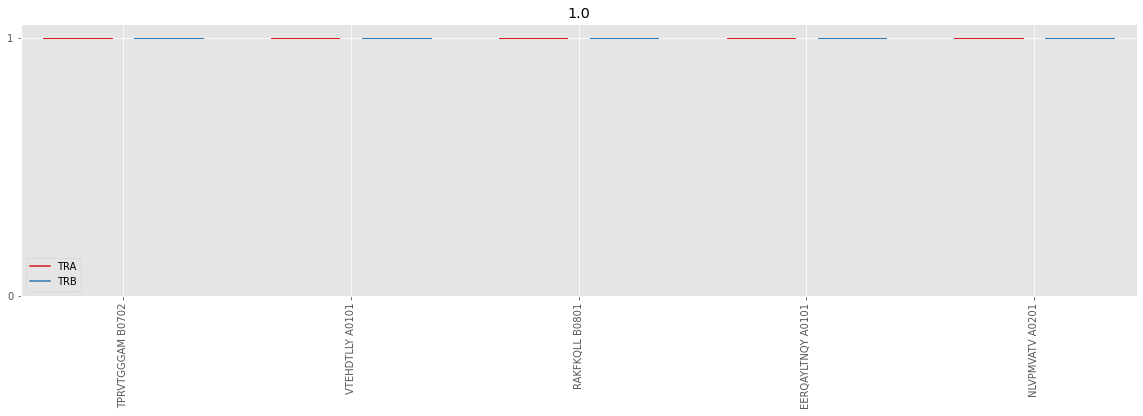

RAKFKQLL B0801
TRA: 1 302 2.0
TRB: 0 302 1.0
VTEHDTLLY A0101
TRA: 0 5 1.0
TRB: 0 5 1.0
TPRVTGGGAM B0702
TRA: 0 1 1.0
TRB: 0 1 1.0
DEYVHNTTA B0801
TRA: 0 1 1.0
TRB: 0 1 1.0
2.0
1.0
2.0


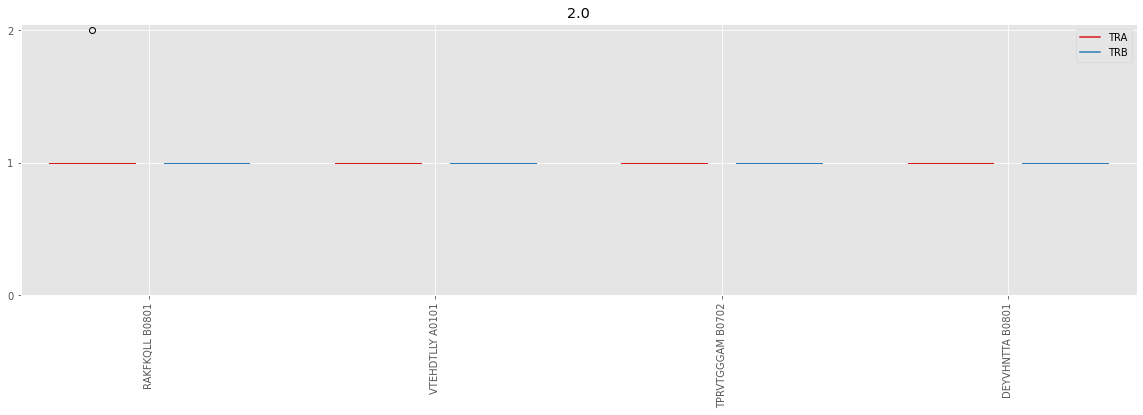

NLVPMVATV A0201
TRA: 0 18 1.0
TRB: 0 18 1.0
ALPGVPPV A0201
TRA: 0 1 1.0
TRB: 0 1 1.0
RAKFKQLL B0801
TRA: 0 1 1.0
TRB: 0 1 1.0
VTEHDTLLY A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
1.0
1.0
1.0


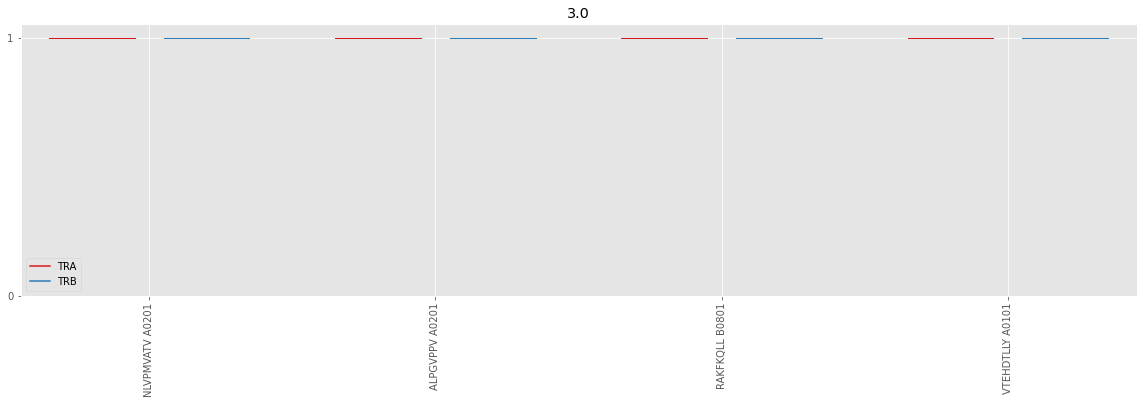

RAKFKQLL B0801
TRA: 0 22 nan
TRB: 0 22 1.0
TPRVTGGGAM B0702
TRA: 0 1 nan
TRB: 0 1 1.0
WPRAPRGQI B0801
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


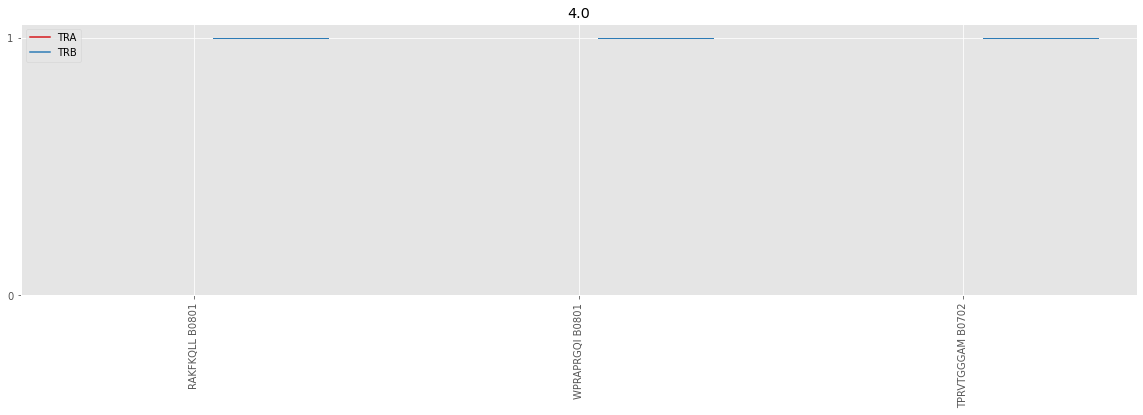

VTEHDTLLY A0101
TRA: 0 78 1.0
TRB: 1 78 2.0
EERQAYLTNQY A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
1.0
2.0
2.0


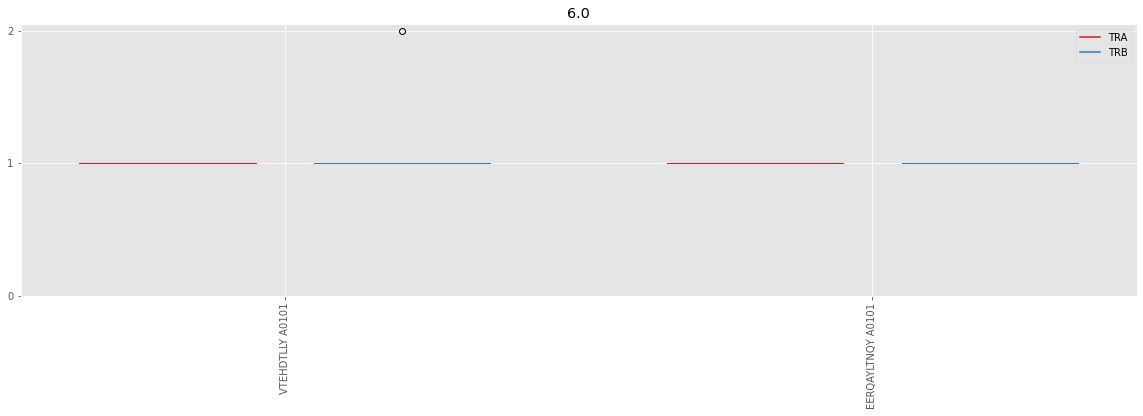

VTEHDTLLY A0101
TRA: 0 64 nan
TRB: 0 64 1.0
EERQAYLTNQY A0101
TRA: 0 2 nan
TRB: 0 2 1.0
NLVPMVATV A0201
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


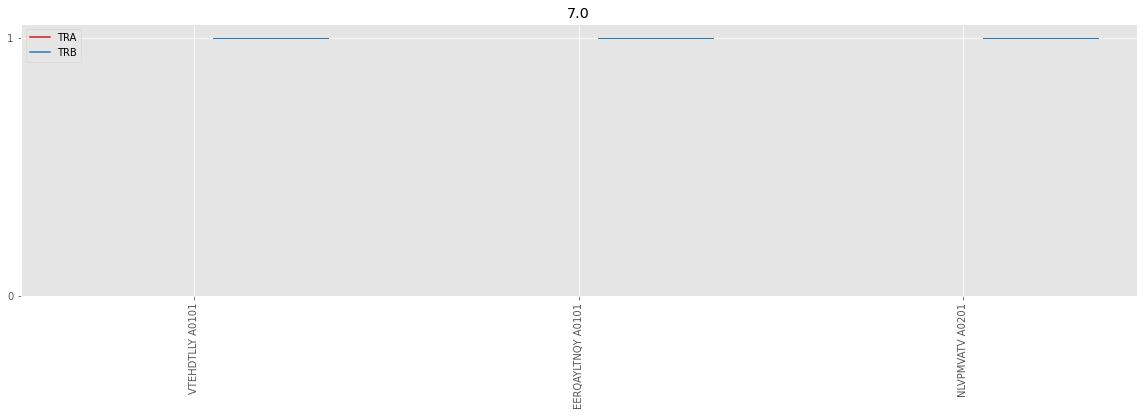

NLVPMVATV A0201
TRA: 0 3 nan
TRB: 0 3 1.0
VTEHDTLLY A0101
TRA: 0 2 nan
TRB: 0 2 1.0
RAKFKQLL B0801
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


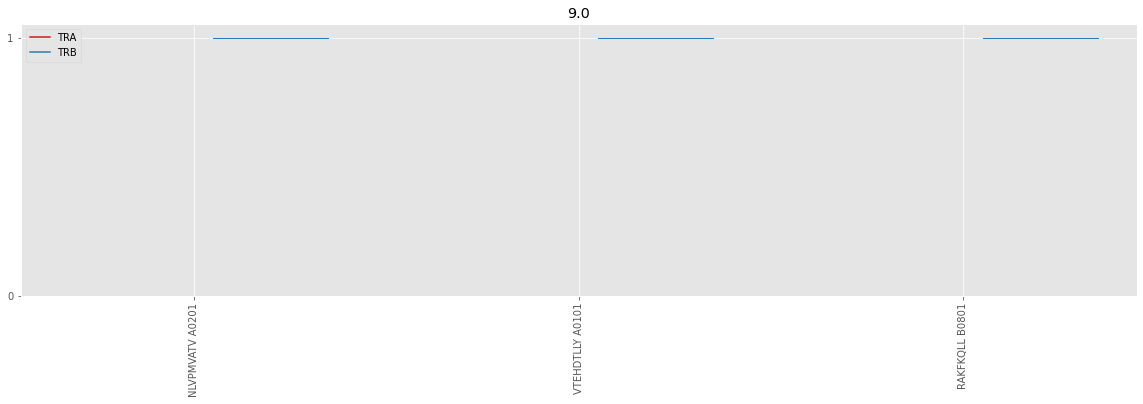

VTEHDTLLY A0101
TRA: 8 34 2.0
TRB: 0 34 1.0
EERQAYLTNQY A0101
TRA: 0 3 1.0
TRB: 0 3 1.0
FSAGAFILYK A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
RAKFKQLL B0801
TRA: 1 1 2.0
TRB: 0 1 1.0
2.0
1.0
2.0


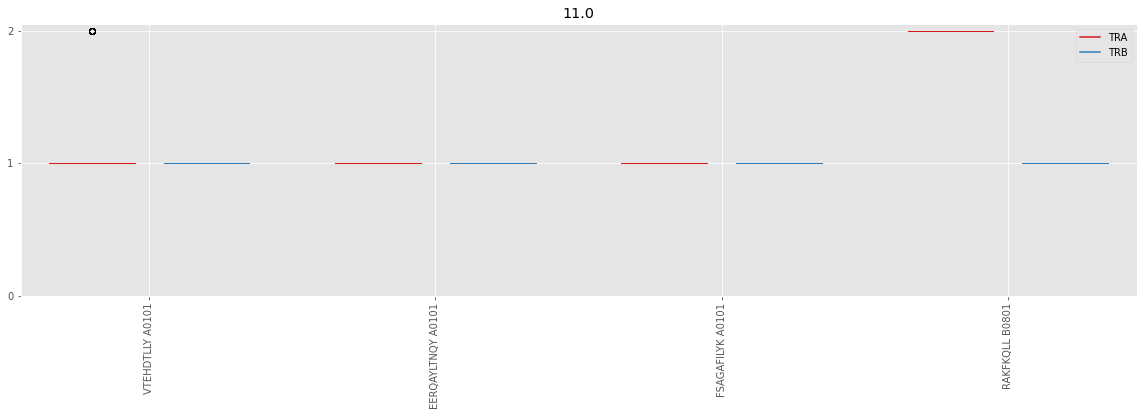

VTEHDTLLY A0101
TRA: 7 18 2.0
TRB: 0 18 1.0
EERQAYLTNQY A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
2.0
1.0
2.0


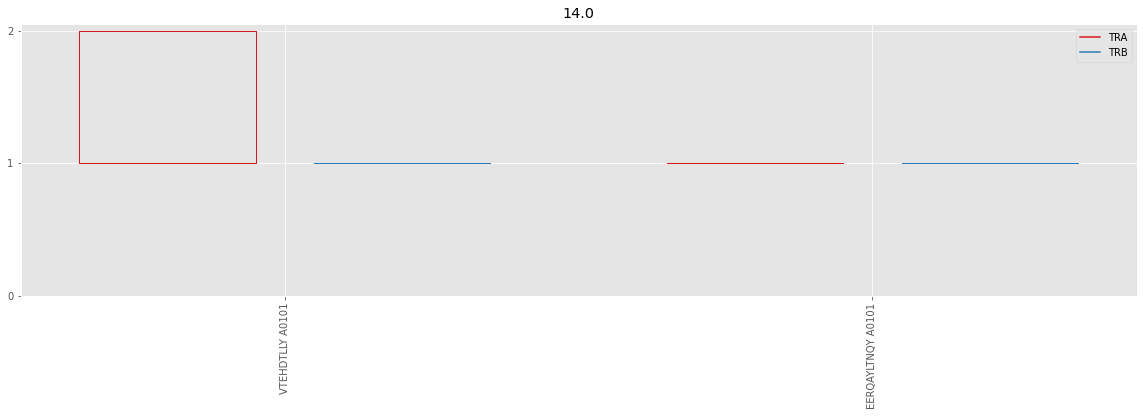

VTEHDTLLY A0101
TRA: 0 16 nan
TRB: 0 16 1.0
RAKFKQLL B0801
TRA: 0 1 nan
TRB: 0 1 1.0
FSAGAFILYK A0101
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


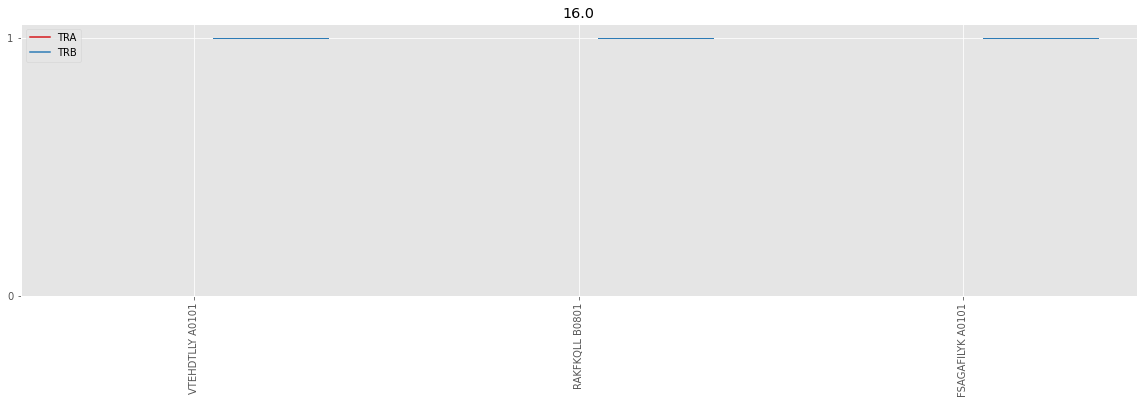

VTEHDTLLY A0101
TRA: 0 3 nan
TRB: 0 3 1.0
EERQAYLTNQY A0101
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


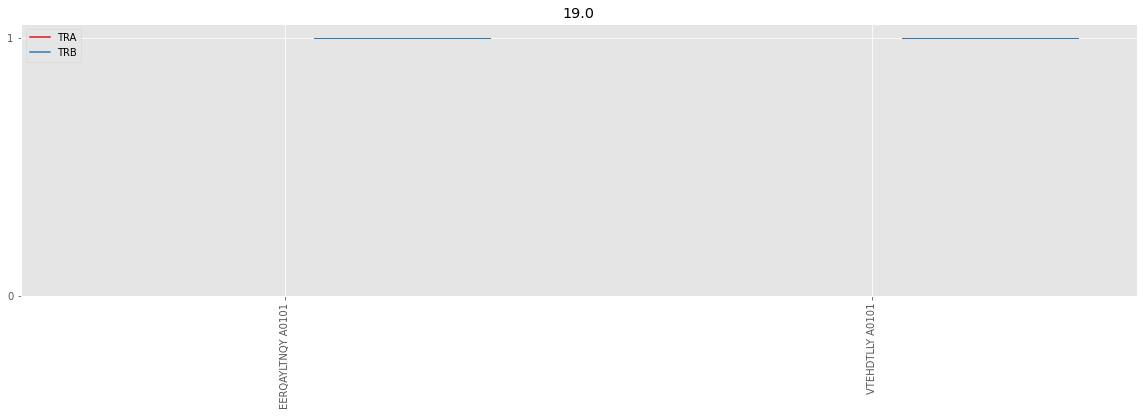

VTEHDTLLY A0101
TRA: 0 11 nan
TRB: 0 11 1.0
EERQAYLTNQY A0101
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


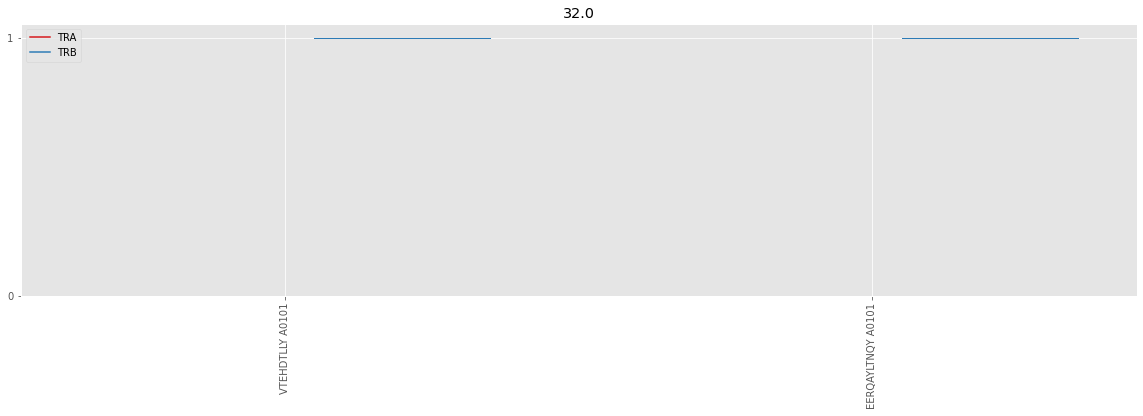

VTEHDTLLY A0101
TRA: 0 8 1.0
TRB: 0 8 1.0
FSAGAFILYK A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
1.0
1.0
1.0


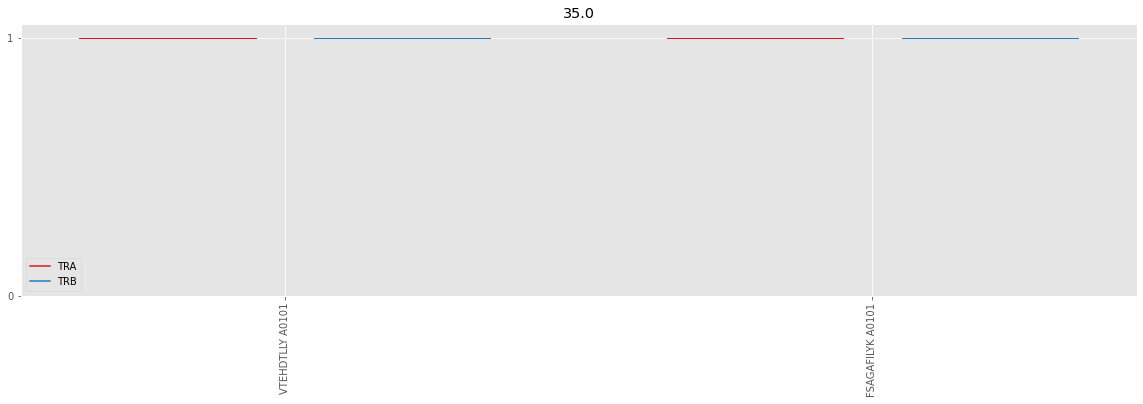

VTEHDTLLY A0101
TRA: 0 2 nan
TRB: 0 2 1.0
EERQAYLTNQY A0101
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


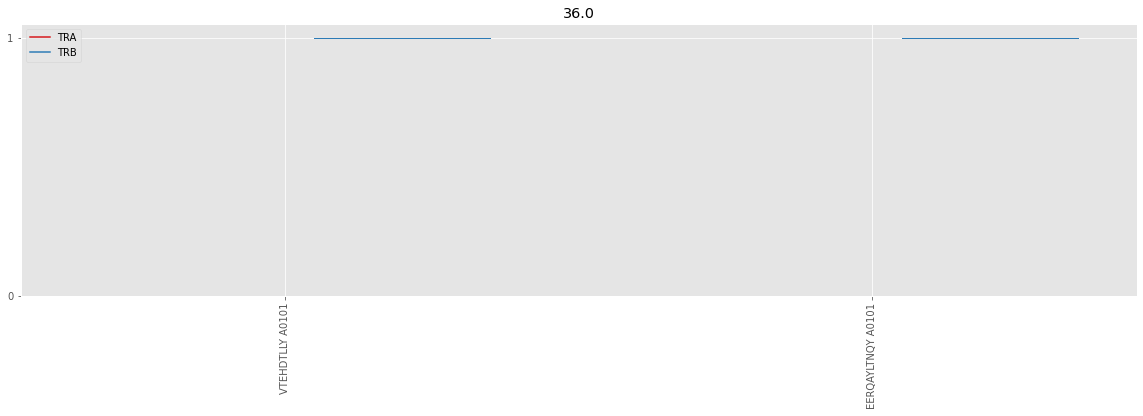

RAKFKQLL B0801
TRA: 2 2 2.0
TRB: 1 2 2.0
NLVPMVATV A0201
TRA: 1 1 2.0
TRB: 1 1 2.0
2.0
2.0
2.0


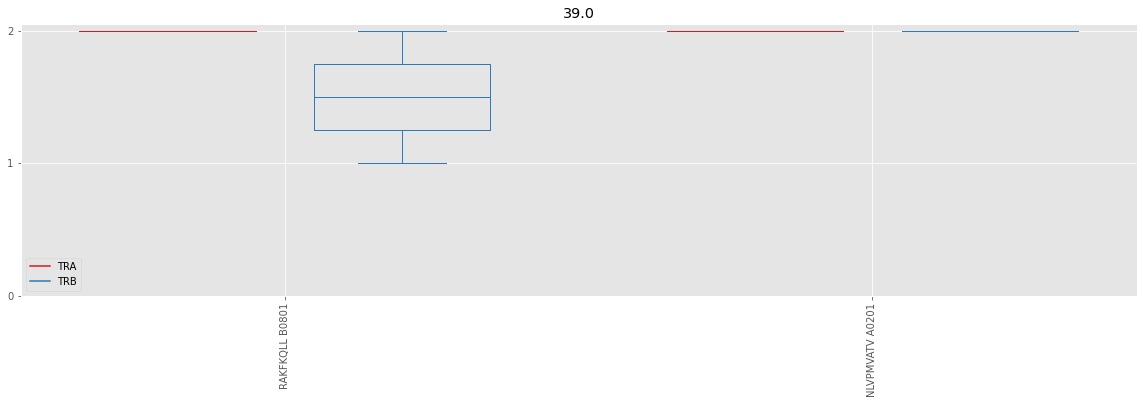

VTEHDTLLY A0101
TRA: 0 2 nan
TRB: 0 2 1.0
EERQAYLTNQY A0101
TRA: 0 1 nan
TRB: 0 1 1.0
0.0
1.0
1.0


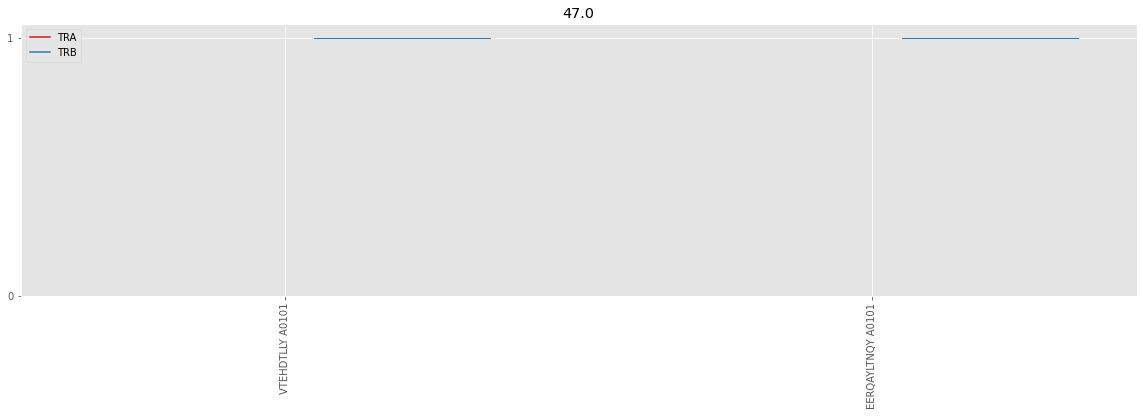

VTEHDTLLY A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
FSAGAFILYK A0101
TRA: 0 1 1.0
TRB: 0 1 1.0
1.0
1.0
1.0


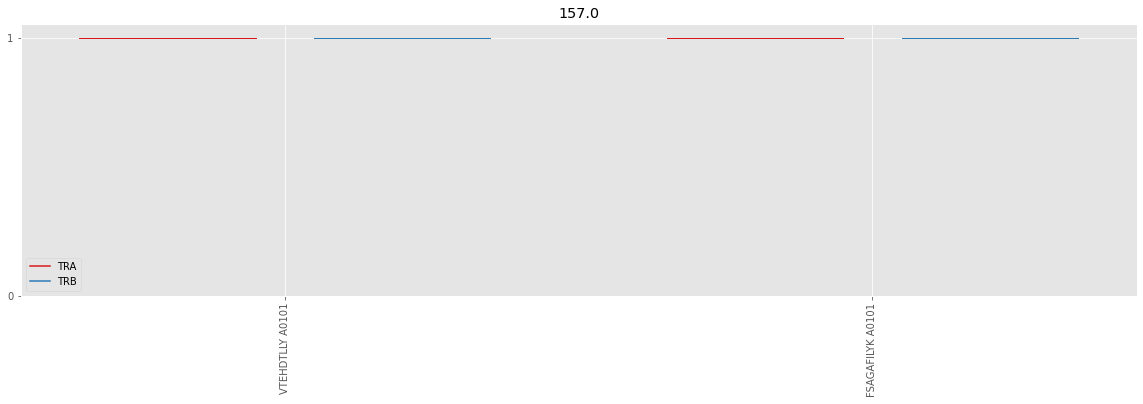

In [20]:
mpl.rcParams['axes.grid'] = True

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
        
#groups = df[df.binding_concordance < 1].groupby('ct')
groups = tmp[tmp.binding_concordance < 1].groupby('ct')
for ct, grp in groups:
    a = list()
    b = list()
    na = list()
    nb = list()
    ma = list()
    mb = list()
    for peptide_HLA, g in grp.sort_values(by='binding_concordance', ascending=False).groupby('peptide_HLA', sort=False):
        print(peptide_HLA)
        ca = g.chain_count_TRA.to_list()
        cb = g.chain_count_TRB.to_list()
        a.append(ca)
        b.append(cb)
        
        na.append(len(ca))
        nb.append(len(cb))
        ma.append(len([i for i in ca if i > 1]))
        mb.append(len([i for i in cb if i > 1]))
        
        print('TRA:', ma[-1], na[-1], max(ca))
        print('TRB:', mb[-1], nb[-1], max(cb))
        
    ticks = grp.peptide_HLA.unique()

    plt.figure(figsize=(20,5))

    bpa = plt.boxplot(a, positions=np.arange(len(a))*2.0-0.4, widths=0.6) #, sym=''
    bpb = plt.boxplot(b, positions=np.arange(len(b))*2.0+0.4, widths=0.6) #, sym=''
    set_box_color(bpa, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpb, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='TRA')
    plt.plot([], c='#2C7BB6', label='TRB')
    plt.legend()

    print(grp.chain_count_TRA.fillna(0).max())
    print(grp.chain_count_TRB.fillna(0).max())
    print(max(grp.chain_count_TRA.fillna(0).max(),grp.chain_count_TRB.fillna(0).max()))
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, rotation=90)
    plt.yticks(np.arange(0, max(grp.chain_count_TRA.fillna(0).max(),grp.chain_count_TRB.fillna(0).max())+1))
        
    plt.title(ct)
    
    #fig, (axa, axb) = plt.subplots(1,2)
    #axa.boxplot(a)
    #axb.boxplot(b)
    #axa.set_title(ct)
    #axb.set_title(ct)
    #axa.set_xticklabels(sorted(grp.peptide_HLA.unique()), rotation=90) #np.arange(1,len(grp.peptide_HLA.unique())+1), 
    #axb.set_xticklabels(sorted(grp.peptide_HLA.unique()), rotation=90) #np.arange(1,len(grp.peptide_HLA.unique())+1), 
    #axa.set_yticklabels(np.arange(0, grp.chain_count_TRA.max()+1), np.arange(0, grp.chain_count_TRA.max()+1))
    #axb.set_yticklabels(np.arange(0, grp.chain_count_TRB.max()+1), np.arange(0, grp.chain_count_TRB.max()+1))
    plt.show()

In [21]:
tmp.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr3_TRA',
       'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA', 'cdr3_lst_TRA',
       'chain_count_TRA', 'single_TRA', 'length_TRB', 'cdr3_TRB',
       'umi_count_TRB', 'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB',
       'chain_count_TRB', 'single_TRB', 'single_chain_only', 'umi_count_tcr',
       'cdr3_comb', 'tcr_category', 'no_filtration',
       'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'multiplets_mhc', 'delta_umi_mhc',
       'template_id_cd8', 'template_lst_cd8', 'single_barcode_cd8',
       'umi_count_cd8', 'umi_count_lst_cd8', 'read_count_cd8',
       'read_count_lst_cd8', 'detected_response', 'peptide_assayed',
       'sample_id', 'sample_id

RAKFKQLL B0801
TRA: 11.0
TRB: 30.0
VTEHDTLLY A0101
TRA: 7.0
TRB: 17.0
TPRVTGGGAM B0702
TRA: 4.0
TRB: 19.0
DEYVHNTTA B0801
TRA: 9.0
TRB: 15.0


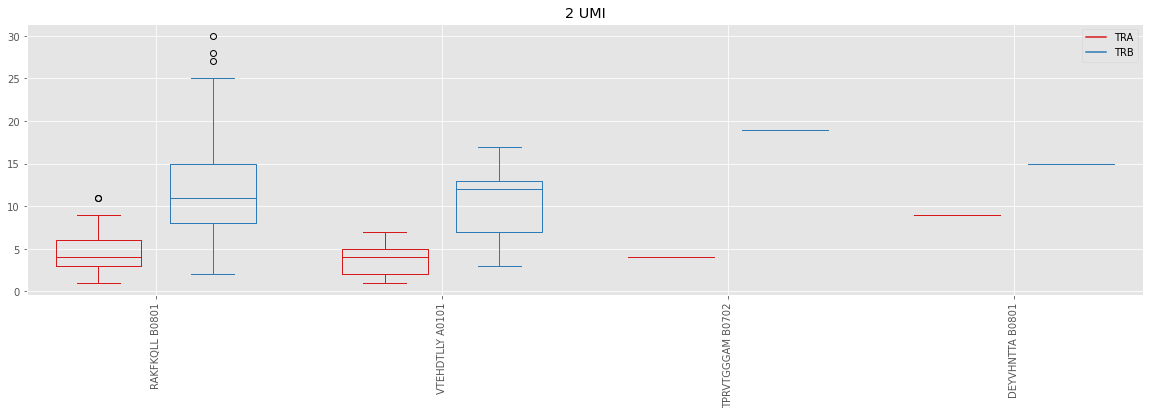

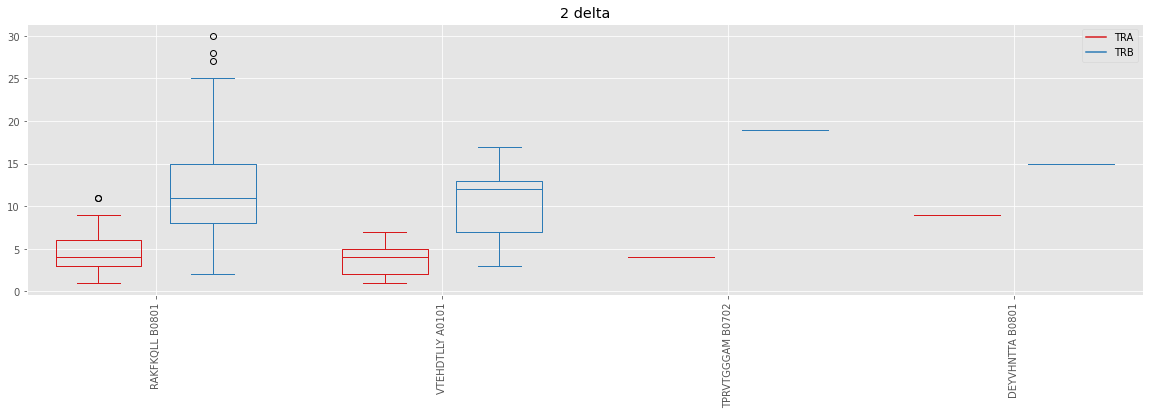

In [28]:
ct = 2
tmptmp = tmp.loc[tmp.ct == ct, ['umi_count_lst_mhc','peptide_lst','peptide_HLA',
                                'cdr3_TRA','cdr3_lst_TRA','genes_TRA','genes_lst_TRA','umi_count_TRA',
                                'cdr3_TRB','cdr3_lst_TRB','genes_TRB','genes_lst_TRB','umi_count_TRB',
                                'delta_umi_TRA','delta_umi_TRB','binding_concordance']].copy()
umi_a, dlt_a = list(), list()
umi_b, dlt_b = list(), list()

for peptide_HLA, g in tmptmp.sort_values(by='binding_concordance', ascending=False).groupby('peptide_HLA', sort=False):
    print(peptide_HLA)
    ua = g.umi_count_TRA.to_list()
    ub = g.umi_count_TRB.to_list()
    da = g.delta_umi_TRA.to_list()
    db = g.delta_umi_TRB.to_list()
    umi_a.append(ua)
    umi_b.append(ub)
    dlt_a.append(ua)
    dlt_b.append(ub)

    print('TRA:', max(ua))
    print('TRB:', max(ub))

ticks = tmptmp.peptide_HLA.unique()

for a, b, title in [(umi_a, umi_b, 'UMI'), (dlt_a, dlt_b, 'delta')]:
    plt.figure(figsize=(20,5))

    bpa = plt.boxplot(a, positions=np.arange(len(a))*2.0-0.4, widths=0.6) #, sym=''
    bpb = plt.boxplot(b, positions=np.arange(len(b))*2.0+0.4, widths=0.6) #, sym=''
    set_box_color(bpa, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpb, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='TRA')
    plt.plot([], c='#2C7BB6', label='TRB')
    plt.legend()
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, rotation=90)

    plt.title('%s %s' %(ct, title))
    plt.show()

In [54]:
tmp.loc[tmp.ct == 32, ['gem','clonotype','umi_count_lst_mhc','peptide_lst','peptide_HLA','cdr3_TRA','cdr3_lst_TRA','genes_TRA','genes_lst_TRA','umi_count_lst_TRA','cdr3_TRB','cdr3_lst_TRB','genes_TRB','genes_lst_TRB','umi_count_lst_TRB']].sort_values(by='peptide_HLA')

,gem,clonotype,umi_count_lst_mhc,peptide_lst,peptide_HLA,cdr3_TRA,cdr3_lst_TRA,genes_TRA,genes_lst_TRA,umi_count_lst_TRA,cdr3_TRB,cdr3_lst_TRB,genes_TRB,genes_lst_TRB,umi_count_lst_TRB
2346,GTTTCTACACTGTTAG-1,NaN,"[1, 1, 1, 2, 2, 41]",['TPRVTGGGAM' 'LFSAGAFILYK' 'LFSAGAFIL' 'SAGAF...,EERQAYLTNQY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[2]
2102,ACGATACTCCTATTCA-1,clonotype6,"[1, 1, 1, 2, 81]",['TADVDAGSLS' 'TNQYMQRMASV' 'FSAGAFILYK' 'ATTA...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[7]
2125,ATAGACCTCGTGACAT-1,clonotype6,"[1, 1, 1, 2, 3, 4, 171]",['TNQYMQRMASV' 'SVDIHFDPG' 'AYLTNQYM' 'FSAGAFI...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[2]
2168,CATGACAGTCAACTGT-1,clonotype6,"[1, 1, 1, 1, 1, 1, 2, 2, 3, 92]",['EERQAYLTNQY' 'DEYVHNTTA' 'QAYLTNQY' 'GMAEGAT...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[7]
2181,CCTACCACATGACATC-1,NaN,"[1, 1, 1, 1, 1, 5, 15, 62]",['TADVDAGSLS' 'AALPGVPPV' 'TPRVTGGGAM' 'FSAGAF...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[1]
2218,CGTGTCTAGATGGCGT-1,NaN,"[1, 1, 1, 2, 27]",['EERQAYLTNQY' 'ALPGVPPVPA' 'FSAGAFILYN' 'RAKF...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[2]
2234,CTCTAATTCAGTTGAC-1,clonotype6,"[1, 1, 1, 1, 1, 1, 76]",['RQAYLTNQY' 'ATTADVDAGSL' 'EERQAYLTNQY' 'NLVP...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[6]
2291,GCGAGAACACGGCTAC-1,NaN,"[1, 1, 1, 2, 3, 4, 4, 5, 5, 6, 245]",['IRHKRQSWV' 'NLVPMVATV' 'FSAGAFILYK' 'GMAEGAT...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[1]
2320,GTAGGCCCAAGTCTAC-1,NaN,"[1, 1, 2, 2, 4, 6, 23, 176]",['SQSDQTSEL' 'GLFSAGAF' 'FSAGAFILYN' 'TPRVTGGG...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[3]
2371,TCAGATGGTCGCGGTT-1,clonotype6,"[1, 1, 1, 1, 2, 3, 4, 4, 6, 209]",['GMAEGATTA' 'RQAYLTNQY' 'FSAGAFILYN' 'YPLVKMR...,VTEHDTLLY A0101,NaN,[],NaN,NaN,[],CASRVQFGVNTGELFF,[CASRVQFGVNTGELFF],TRBV19;;TRBJ2-2;TRBC2,['TRBV19;;TRBJ2-2;TRBC2'],[3]


In [52]:
tmp.loc[tmp.cdr3_TRA == 'CAARPGAQKLVF', ['ct','umi_count_lst_mhc','peptide_lst','peptide_HLA','cdr3_TRA','cdr3_lst_TRA','genes_TRA','genes_lst_TRA','umi_count_lst_TRA','cdr3_TRB','cdr3_lst_TRB','genes_TRB','genes_lst_TRB','umi_count_lst_TRB']].sort_values(by='ct')

,ct,umi_count_lst_mhc,peptide_lst,peptide_HLA,cdr3_TRA,cdr3_lst_TRA,genes_TRA,genes_lst_TRA,umi_count_lst_TRA,cdr3_TRB,cdr3_lst_TRB,genes_TRB,genes_lst_TRB,umi_count_lst_TRB
14,13.0,"[1, 1, 28]",['ATTADVDAGSL' 'RAKFKQLL' 'VTEHDTLLY'],VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[2],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[12]
1931,13.0,"[1, 1, 1, 3, 34]",['SVDIHFDPGF' 'EERQAYLTNQY' 'GMAEGATTA' 'RAKFK...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[1],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[11]
1922,13.0,"[1, 1, 1, 1, 1, 3, 82]",['RQAYLTNQY' 'QAYLTNQY' 'ATTADVDAGSL' 'FSAGAFI...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[3],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[15]
1916,13.0,"[1, 1, 1, 2, 2, 2, 3, 4, 5, 9, 10, 397]",['SVDIHFDPGF' 'FSAGAFILYK' 'TPRVTGGGAM' 'RQAYL...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[4],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[21]
1857,13.0,"[1, 1, 1, 1, 1, 1, 2, 81]",['TNQYMQRMASV' 'RQAYLTNQY' 'RAKFKQLL' 'WPRAPRG...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[2],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[14]
1808,13.0,"[1, 2, 2, 2, 3, 4, 98]",['RAKFKQLL' 'QAYLTNQY' 'GMAEGATTA' 'FSAGAFILYN...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[3],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[10]
1262,13.0,"[1, 1, 1, 1, 2, 7, 127]",['FSAGAFILYN' 'TNQYMQRMASV' 'GMAEGATTA' 'AYLTN...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[2],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[8]
1245,13.0,"[1, 1, 1, 1, 1, 1, 1, 3, 120]",['ILKEPVHGV' 'FSAGAFILYK' 'RQAYLTNQY' 'SVDIHFD...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[4],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[25]
1207,13.0,"[1, 1, 22]",['ATTADVDAGSL' 'TNQYMQRMASV' 'VTEHDTLLY'],VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[2],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[13]
1185,13.0,"[1, 1, 1, 1, 1, 2, 85]",['NLVPMVATV' 'QAYLTNQY' 'ATTADVDAGSL' 'RQAYLTN...,VTEHDTLLY A0101,CAARPGAQKLVF,[CAARPGAQKLVF],TRAV29/DV5;TRAJ54;TRAC,['TRAV29/DV5;TRAJ54;TRAC'],[3],CASSLEAGQKPYEQYF,[CASSLEAGQKPYEQYF],TRBV7-9;;TRBJ2-7;TRBC2,['TRBV7-9;;TRBJ2-7;TRBC2'],[9]


In [78]:
tmp.loc[tmp.cdr3_TRB == 'CASSLIVSGGANEQFF', ['ct','umi_count_lst_mhc','peptide_lst','peptide_HLA','cdr3_TRA','cdr3_lst_TRA','genes_TRA','genes_lst_TRA','umi_count_lst_TRA','cdr3_TRB','cdr3_lst_TRB','genes_TRB','genes_lst_TRB','umi_count_lst_TRB']]

,ct,umi_count_lst_mhc,peptide_lst,peptide_HLA,cdr3_TRA,cdr3_lst_TRA,genes_TRA,genes_lst_TRA,umi_count_lst_TRA,cdr3_TRB,cdr3_lst_TRB,genes_TRB,genes_lst_TRB,umi_count_lst_TRB
0,2.0,"[1, 1, 1, 2, 3, 68]",['ALPGVPPV' 'RQAYLTNQY' 'VTEHDTLLY' 'EERQAYLTN...,RAKFKQLL B0801,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],TRAV16;TRAJ47;TRAC,['TRAV16;TRAJ47;TRAC'],[2],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[10]
6,2.0,"[1, 1, 1, 1, 1, 1, 3, 71]",['TPRVTGGGAM' 'LLFERPHTM' 'HTGEKHYAC' 'FSAGAFI...,RAKFKQLL B0801,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],TRAV16;TRAJ47;TRAC,['TRAV16;TRAJ47;TRAC'],[2],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[12]
7,39.0,"[1, 1, 1, 2, 4, 6, 87]",['TPRVTGGGAM' 'IRHKRQSWV' 'EERQAYLTNQY' 'MDMFS...,RAKFKQLL B0801,CAVNYGNKLVF,"[CALRDMEYGNKLVF, CAVNYGNKLVF]",TRAV3;TRAJ47;TRAC,['TRAV16;TRAJ47;TRAC' 'TRAV3;TRAJ47;TRAC'],"[2, 4]",CASSLIVSGGANEQFF,"[CASSLVAGAPSEQYF, CASSLIVSGGANEQFF]",TRBV7-3;;TRBJ2-1;TRBC2,['TRBV27;;TRBJ2-7;TRBC2' 'TRBV7-3;;TRBJ2-1;TRB...,"[7, 19]"
11,2.0,"[1, 1, 2, 3, 50]",['VIRHKRQSW' 'SQKVLRHM' 'VTEHDTLLY' 'AMLIRDRL'...,RAKFKQLL B0801,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],TRAV16;TRAJ47;TRAC,['TRAV16;TRAJ47;TRAC'],[6],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[5]
17,2.0,[27],['RAKFKQLL'],RAKFKQLL B0801,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],TRAV16;TRAJ47;TRAC,['TRAV16;TRAJ47;TRAC'],[3],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[7]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,4.0,"[1, 1, 1, 36]",['IRHKRQSWV' 'VTEHDTLLY' 'FSAGAFILYK' 'RAKFKQLL'],RAKFKQLL B0801,NaN,[],NaN,NaN,[],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[8]
2332,4.0,"[1, 1, 1, 1, 69]",['AMLIRDRL' 'IRHKRQSWV' 'VIRHKRQSW' 'LLFERPHTM...,RAKFKQLL B0801,NaN,[],NaN,NaN,[],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[10]
2352,4.0,"[1, 1, 1, 1, 4, 57]",['VTEHDTLLY' 'VIRHKRQSW' 'HTGEKHYAC' 'MDMFSDEQ...,RAKFKQLL B0801,NaN,[],NaN,NaN,[],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[15]
2380,4.0,"[1, 19]",['AMLIRDRL' 'RAKFKQLL'],RAKFKQLL B0801,NaN,[],NaN,NaN,[],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],TRBV7-3;;TRBJ2-1;TRBC2,['TRBV7-3;;TRBJ2-1;TRBC2'],[11]


In [79]:
df.loc[df.ct == 11, ['umi_count_lst_mhc','peptide_lst','peptide_HLA','cdr3_TRA','cdr3_lst_TRA','genes_TRA','genes_lst_TRA','umi_count_lst_TRA','cdr3_TRB','cdr3_lst_TRB','genes_TRB','genes_lst_TRB','umi_count_lst_TRB']]

,umi_count_lst_mhc,peptide_lst,peptide_HLA,cdr3_TRA,cdr3_lst_TRA,genes_TRA,genes_lst_TRA,umi_count_lst_TRA,cdr3_TRB,cdr3_lst_TRB,genes_TRB,genes_lst_TRB,umi_count_lst_TRB
95,"[1, 1, 1, 2, 2, 4, 7, 7, 44]",['AYLTNQYM' 'TNQYMQRMASV' 'QAYLTNQY' 'ATTADVDA...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[3],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[7]
144,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 6, 188]",['TPRVTGGGAM' 'GMAEGATTA' 'FSAGAFILYK' 'GPFPGN...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[4],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[13]
168,"[1, 1, 1, 1, 1, 88]",['ATTADVDAGSL' 'FSAGAFILYN' 'TNQYMQRMASV' 'QAY...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[5],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[9]
181,"[1, 1, 2, 3, 6, 109]",['FLVNTMCLAL' 'GMAEGATTA' 'EERQAYLTNQY' 'RQAYL...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[5],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[11]
223,"[1, 1, 1, 3, 4, 24, 141]",['FSAGAFILYK' 'RQAYLTNQY' 'SVDIHFDPG' 'RAKFKQL...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[3],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[14]
262,"[1, 1, 2, 2, 8, 8, 255]",['QAYLTNQY' 'GMAEGATTA' 'SVDIHFDPG' 'TNQYMQRMA...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,"[CAVEDRLDNDMRF, CAAFRAYNTDKLIF]",TRAV29/DV5;TRAJ34;TRAC,['TRAV2;TRAJ43;TRAC' 'TRAV29/DV5;TRAJ34;TRAC'],"[3, 3]",CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[10]
282,"[1, 1, 2, 2, 71]",['CSSVDIHF' 'RQAYLTNQY' 'FSAGAFILYN' 'RAKFKQLL...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[3],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[3]
367,"[1, 1, 1, 1, 2, 29, 59]",['ATTADVDAGSL' 'LTNQYMQRM' 'TADVDAGSLSY' 'RAKF...,VTEHDTLLY A0101,CAAFRAYNTDKLIF,"[CAVEDRLDNDMRF, CAAFRAYNTDKLIF]",TRAV29/DV5;TRAJ34;TRAC,['TRAV2;TRAJ43;TRAC' 'TRAV29/DV5;TRAJ34;TRAC'],"[2, 2]",CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[10]
420,[25],['VTEHDTLLY'],VTEHDTLLY A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[5],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[10]
579,"[1, 1, 1, 1, 15, 23]",['GLFSAGAFIL' 'TADVDAGSLSY' 'RAKFKQLL' 'EERQAY...,FSAGAFILYK A0101,CAAFRAYNTDKLIF,[CAAFRAYNTDKLIF],TRAV29/DV5;TRAJ34;TRAC,['TRAV29/DV5;TRAJ34;TRAC'],[3],CSARGLGQAKEYGYTF,[CSARGLGQAKEYGYTF],TRBV20-1;;TRBJ1-2;TRBC1,['TRBV20-1;;TRBJ1-2;TRBC1'],[5]


In [63]:
sum(tmp[tmp.ct == 157].umi_count_lst_mhc.apply(lambda x: len(x)) > 1)

2

In [16]:
ca = [1,1,1,3,1,1,2,1]
[i for i in ca if i > 1]

[3, 2]

In [163]:
df.chain_count_TRB.value_counts()

1.0    2254
2.0      95
3.0       4
Name: chain_count_TRB, dtype: int64

In [167]:
df.cdr3_lst_TRA

0           [CALRDMEYGNKLVF]
1              [CAASQNEKLTF]
2              [CAASQNEKLTF]
3       [CAVTAPAYSGAGSYQLTF]
4             [CAVNSKGYKLSF]
                ...         
2427                      []
2428                      []
2429                      []
2430                      []
2431                      []
Name: cdr3_lst_TRA, Length: 2432, dtype: object

### Total Data

In [15]:
total_t = df.fillna('None').explode('cdr3_lst_TRA').explode('cdr3_lst_TRB').groupby(['ct','cdr3_lst_TRA','cdr3_lst_TRB']).peptide_HLA.unique().apply(lambda x: x[0]).to_frame()

In [16]:
total_t['peptide_HLA_lst'] = df.fillna('None').explode('cdr3_lst_TRA').explode('cdr3_lst_TRB').groupby(['ct','cdr3_lst_TRA','cdr3_lst_TRB']).peptide_HLA.unique()

In [17]:
total_t['gem_count'] = df.fillna('None').explode('cdr3_lst_TRA').explode('cdr3_lst_TRB').groupby(['ct','cdr3_lst_TRA','cdr3_lst_TRB']).gem.count()

In [18]:
total_t['color'] = total_t.peptide_HLA_lst.apply(lambda x: 'blue' if len(x)==1 else 'grey')

In [19]:
total_t.reset_index(inplace=True)

In [20]:
total_t.cdr3_lst_TRA.replace(to_replace='', value='None', inplace=True)
total_t.cdr3_lst_TRB.replace(to_replace='', value='None', inplace=True)

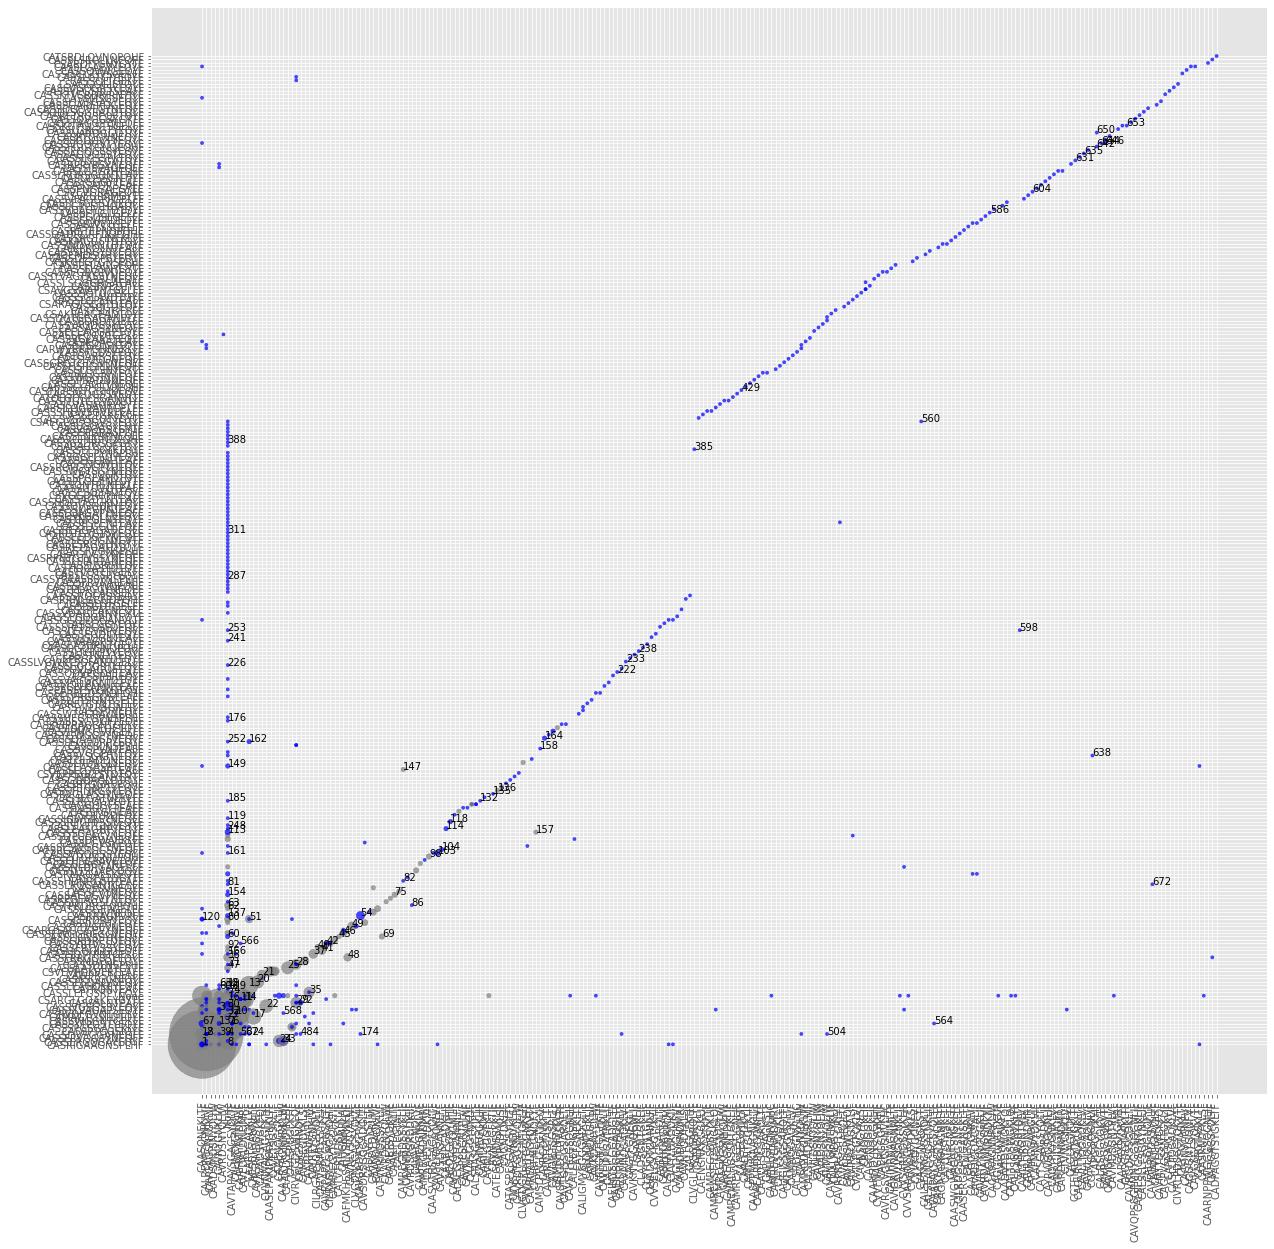

In [21]:
fig = plt.figure(figsize=(20,20))
plt.scatter(total_t.cdr3_lst_TRA, total_t.cdr3_lst_TRB, c=total_t.color, s=total_t.gem_count*10, alpha=0.7)


ax = plt.gca()
for i, txt in enumerate(table.ct.astype(int)):
    ax.annotate(txt, (table.cdr3_TRA[i], table.cdr3_TRB[i]))
    
plt.xticks(rotation=90)
plt.savefig('cdr3_duplicates.png')
plt.show()

### Per ct

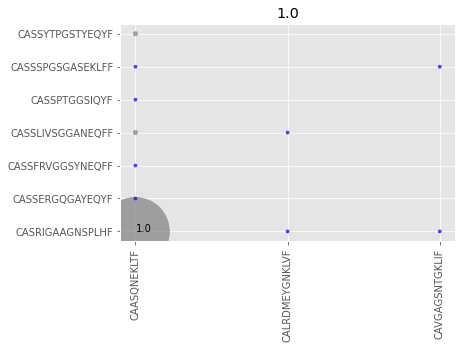

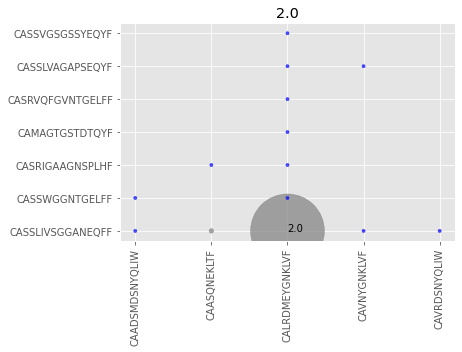

In [22]:
for ct, grp in total_t.groupby('ct'):
    fig = plt.figure()
    plt.scatter(grp.cdr3_lst_TRA, grp.cdr3_lst_TRB, c=grp.color, s=grp.gem_count*10, alpha=0.7)
    plt.title(str(ct))

    ax = plt.gca()
    #for i, txt in enumerate(table.ct.astype(int)):
    if ct in set(table.ct):
        ax.annotate(str(ct), (table.loc[table.ct == ct, 'cdr3_TRA'], table.loc[table.ct == ct, 'cdr3_TRB']))

    plt.xticks(rotation=90)
    plt.show()
    
    if ct == 2:
        break

In [23]:
grp

,ct,cdr3_lst_TRA,cdr3_lst_TRB,peptide_HLA,peptide_HLA_lst,gem_count,color
11,2.0,CAADSMDSNYQLIW,CASSLIVSGGANEQFF,RAKFKQLL B0801,[RAKFKQLL B0801],1,blue
12,2.0,CAADSMDSNYQLIW,CASSWGGNTGELFF,RAKFKQLL B0801,[RAKFKQLL B0801],1,blue
13,2.0,CAASQNEKLTF,CASRIGAAGNSPLHF,RAKFKQLL B0801,[RAKFKQLL B0801],1,blue
14,2.0,CAASQNEKLTF,CASSLIVSGGANEQFF,RAKFKQLL B0801,"[RAKFKQLL B0801, NLVPMVATV A0201]",2,grey
15,2.0,CALRDMEYGNKLVF,CAMAGTGSTDTQYF,VTEHDTLLY A0101,[VTEHDTLLY A0101],1,blue
16,2.0,CALRDMEYGNKLVF,CASRIGAAGNSPLHF,RAKFKQLL B0801,[RAKFKQLL B0801],1,blue
17,2.0,CALRDMEYGNKLVF,CASRVQFGVNTGELFF,VTEHDTLLY A0101,[VTEHDTLLY A0101],1,blue
18,2.0,CALRDMEYGNKLVF,CASSLIVSGGANEQFF,RAKFKQLL B0801,"[RAKFKQLL B0801, VTEHDTLLY A0101, EERQAYLTNQY ...",545,grey
19,2.0,CALRDMEYGNKLVF,CASSLVAGAPSEQYF,RAKFKQLL B0801,[RAKFKQLL B0801],1,blue
20,2.0,CALRDMEYGNKLVF,CASSVGSGSSYEQYF,VTEHDTLLY A0101,[VTEHDTLLY A0101],1,blue


In [33]:
df.loc[df.ct == 2, ['cdr3_TRA','cdr3_lst_TRA','cdr3_TRB','cdr3_lst_TRB','peptide_HLA','peptide_lst']].head(60) #,

,cdr3_TRA,cdr3_lst_TRA,cdr3_TRB,cdr3_lst_TRB,peptide_HLA,peptide_lst
0,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['ALPGVPPV' 'RQAYLTNQY' 'VTEHDTLLY' 'EERQAYLTN...
6,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['TPRVTGGGAM' 'LLFERPHTM' 'HTGEKHYAC' 'FSAGAFI...
11,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['VIRHKRQSW' 'SQKVLRHM' 'VTEHDTLLY' 'AMLIRDRL'...
16,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['VTEHDTLLY' 'RAKFKQLL']
17,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['RAKFKQLL']
24,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],VTEHDTLLY A0101,['VTEHDTLLY']
27,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['IRHKRQSWV' 'VTEHDTLLY' 'RAKFKQLL']
31,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['AMLIRDRL' 'RAKFKQLL']
38,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],RAKFKQLL B0801,['TPRVTGGGAM' 'VTEHDTLLY' 'EERQAYLTNQY' 'SQKVL...
42,CALRDMEYGNKLVF,[CALRDMEYGNKLVF],CASSLIVSGGANEQFF,[CASSLIVSGGANEQFF],VTEHDTLLY A0101,['EERQAYLTNQY' 'VTEHDTLLY']


In [28]:
df

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr3_TRA,...,likely_HLA_mhc,peptide,peptide_lst,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance
0,AAACCTGAGAGGTAGA-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],509.0,CALRDMEYGNKLVF,...,NaN,RAKFKQLL,['ALPGVPPV' 'RQAYLTNQY' 'VTEHDTLLY' 'EERQAYLTN...,RAKFKQLL B0801,"[ALPGVPPV A0201, RQAYLTNQY A0101, VTEHDTLLY A0...",V17_B8 EBV BZLF1 (C9),['06_1_1' '45_1_49' 'V15_A1 CMV pp50 VTE' '...,390.0,575.0,0.678261
1,AAACCTGAGCACCGTC-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],505.0,CAASQNEKLTF,...,NaN,VTEHDTLLY,['GPFPGNLVD' 'WAGGLGLNL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[GPFPGNLVD B0702, WAGGLGLNL B0702, VTEHDTLLY A...",V15_A1 CMV pp50 VTE,['47_1_38' '47_1_62' 'V15_A1 CMV pp50 VTE'],163.0,496.0,0.328629
2,AAACCTGAGGAGCGTT-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],514.0,CAASQNEKLTF,...,NaN,RAKFKQLL,['RAKFKQLL'],RAKFKQLL B0801,[RAKFKQLL B0801],V17_B8 EBV BZLF1 (C9),['V17_B8 EBV BZLF1 (C9)'],106.0,496.0,0.213710
3,AAACCTGAGTCGAGTG-1,clonotype4,4.0,6.0,TRAV39;TRAJ28;TRAC,TRBV4-2;;TRBJ2-7;TRBC2,['TRAV39;TRAJ28;TRAC'],['TRBV4-2;;TRBJ2-7;TRBC2'],487.0,CAVTAPAYSGAGSYQLTF,...,NaN,VTEHDTLLY,['VTEHDTLLY'],VTEHDTLLY A0101,[VTEHDTLLY A0101],V15_A1 CMV pp50 VTE,['V15_A1 CMV pp50 VTE'],151.0,177.0,0.853107
4,AAACCTGCATACTACG-1,clonotype256,256.0,533.0,TRAV12-2;TRAJ20;TRAC,TRBV5-8;TRBD1;TRBJ1-4;TRBC1,['TRAV12-2;TRAJ20;TRAC'],['TRBV5-8;TRBD1;TRBJ1-4;TRBC1'],541.0,CAVNSKGYKLSF,...,NaN,VTEHDTLLY,['VTEHDTLLY'],VTEHDTLLY A0101,[VTEHDTLLY A0101],V15_A1 CMV pp50 VTE,['V15_A1 CMV pp50 VTE'],1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,TTGGAACGTAACGACG-1,clonotype2,2.0,4.0,NaN,TRBV7-3;;TRBJ2-1;TRBC2,NaN,['TRBV7-3;;TRBJ2-1;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['VTEHDTLLY'],VTEHDTLLY A0101,[VTEHDTLLY A0101],V15_A1 CMV pp50 VTE,['V15_A1 CMV pp50 VTE'],113.0,575.0,0.196522
2428,TTTATGCGTCGGATCC-1,clonotype18,18.0,74.0,NaN,TRBV7-9;;TRBJ2-7;TRBC2,NaN,['TRBV7-9;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,EERQAYLTNQY,['EERQAYLTNQY'],EERQAYLTNQY A0101,[EERQAYLTNQY A0101],45_1_3,['45_1_3'],2.0,15.0,0.133333
2429,TTTCCTCAGCACGCCT-1,clonotype6,6.0,32.0,NaN,TRBV19;;TRBJ2-2;TRBC2,NaN,['TRBV19;;TRBJ2-2;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['RQAYLTNQY' 'ATTADVDAGSL' 'QAYLTNQY' 'RAKFKQL...,VTEHDTLLY A0101,"[RQAYLTNQY A0101, ATTADVDAGSL A0101, QAYLTNQY ...",V15_A1 CMV pp50 VTE,['45_1_49' '45_1_1' '45_1_25' 'V17_B8 EBV BZLF...,71.0,74.0,0.959459
2430,TTTCCTCTCGGTCTAA-1,clonotype4,4.0,7.0,NaN,TRBV4-2;;TRBJ2-7;TRBC2,NaN,['TRBV4-2;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['RAKFKQLL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[RAKFKQLL B0801, VTEHDTLLY A0101]",V15_A1 CMV pp50 VTE,['V17_B8 EBV BZLF1 (C9)' 'V15_A1 CMV pp50 V...,151.0,177.0,0.853107


### Per peptide

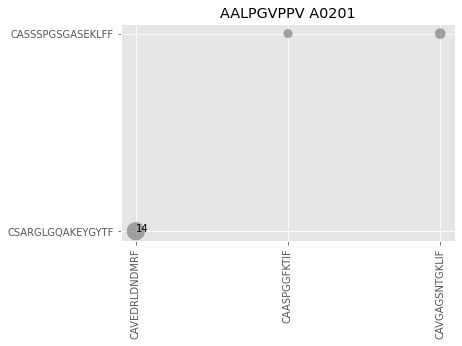

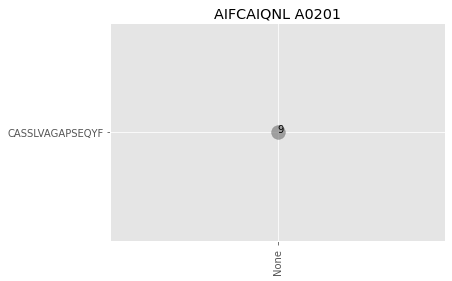

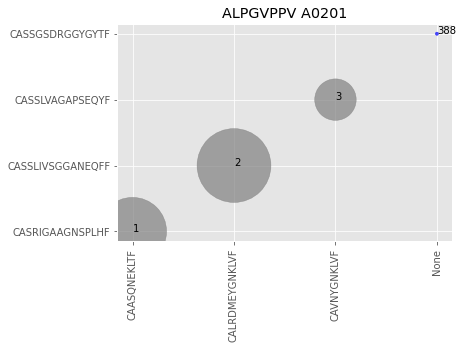

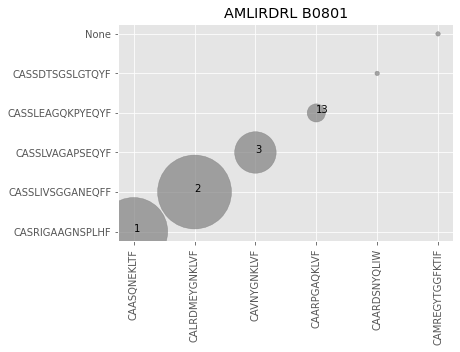

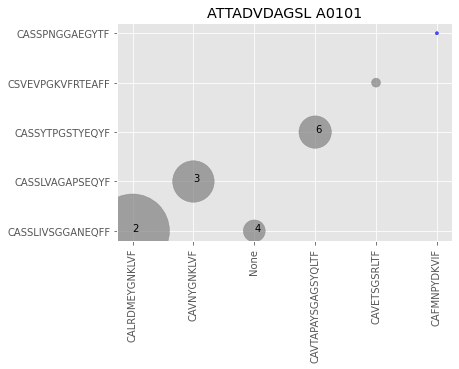

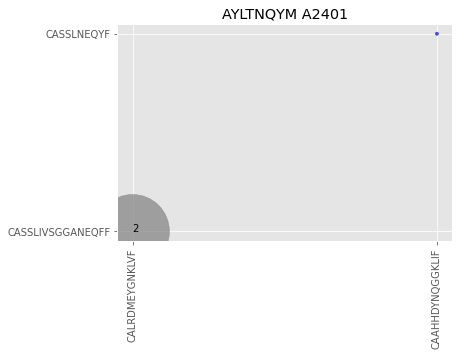

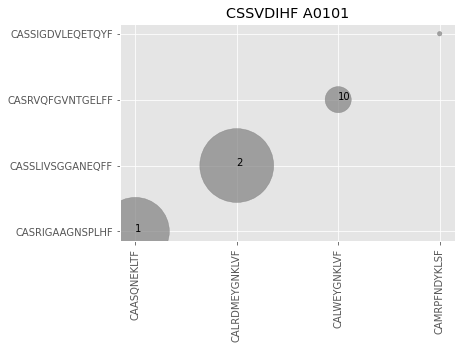

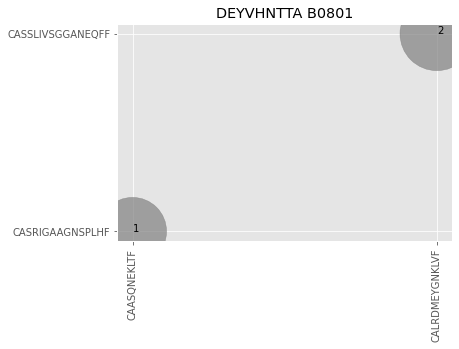

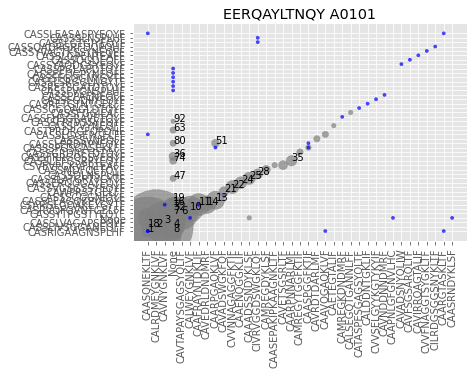

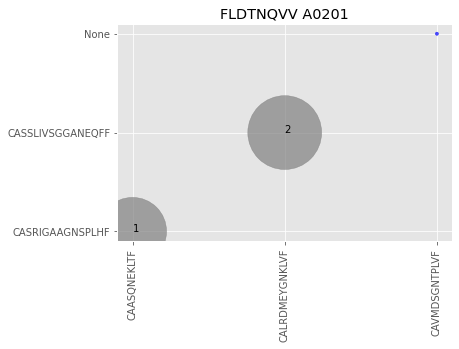

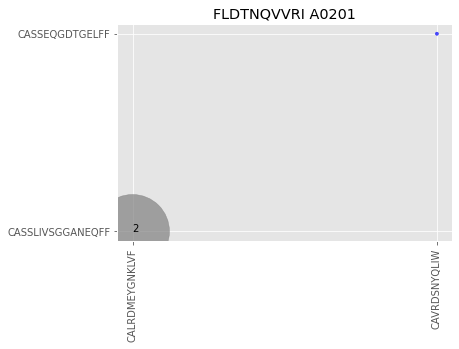

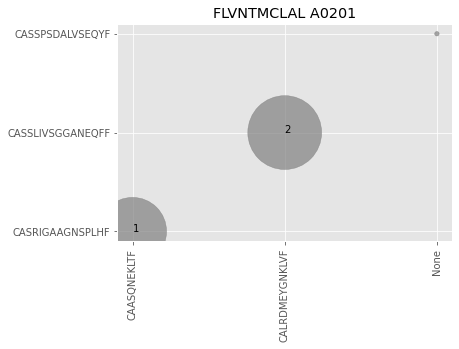

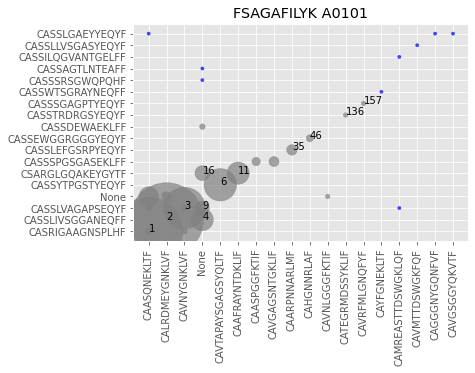

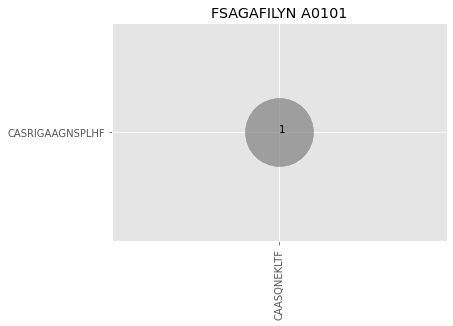

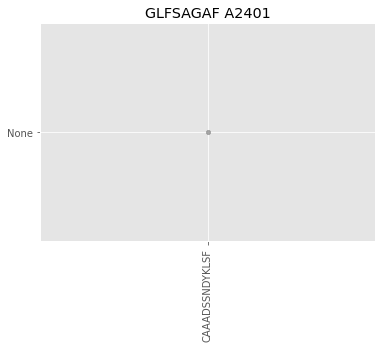

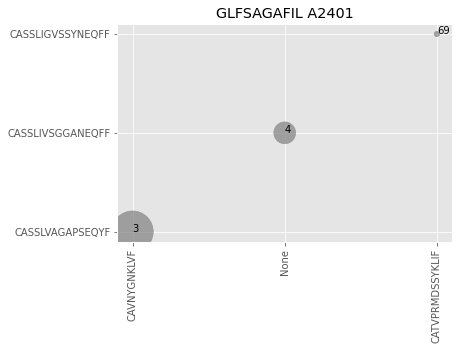

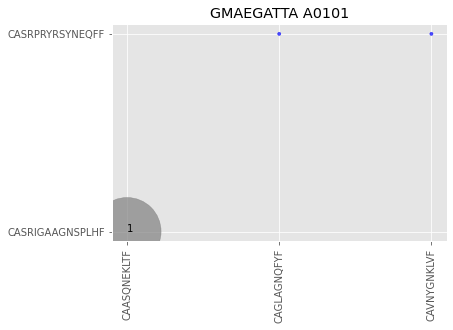

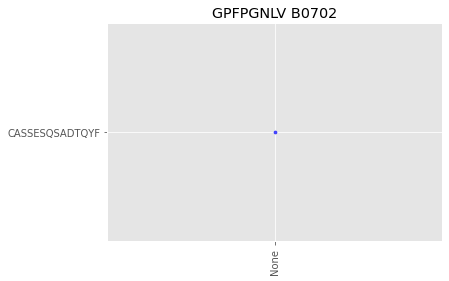

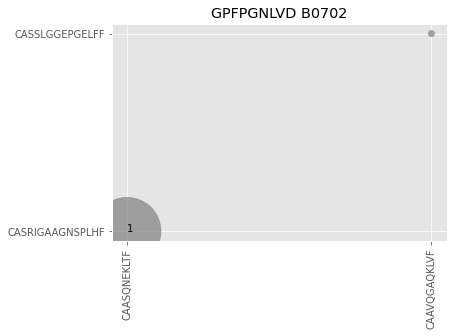

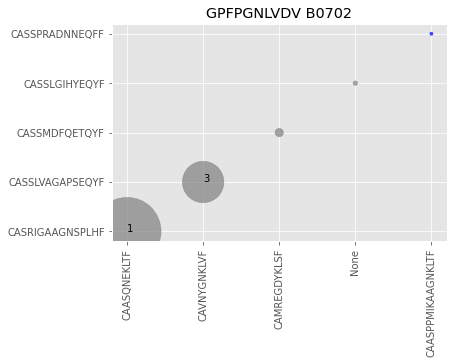

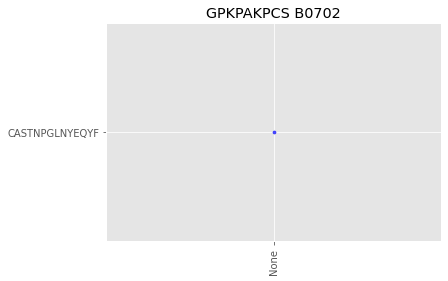

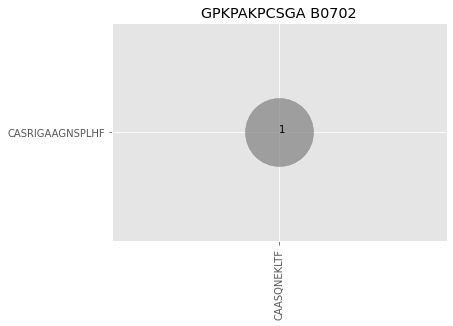

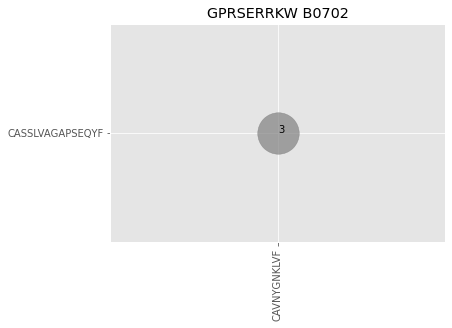

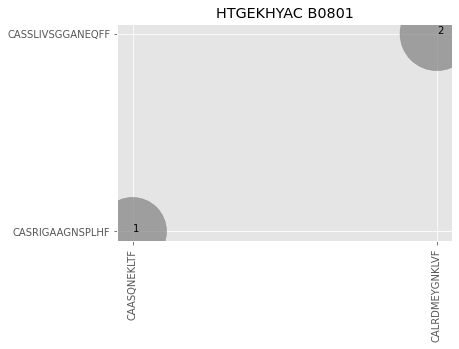

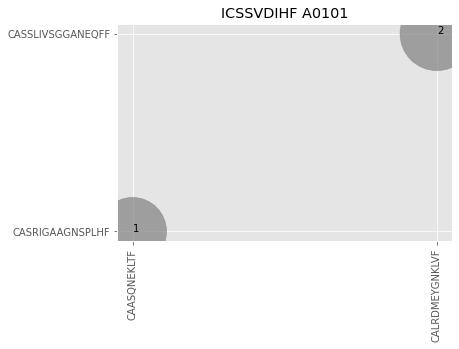

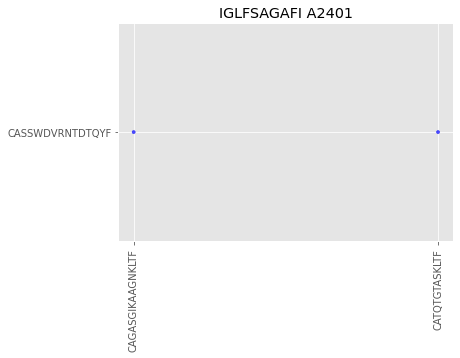

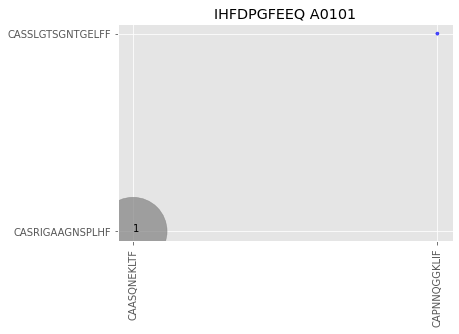

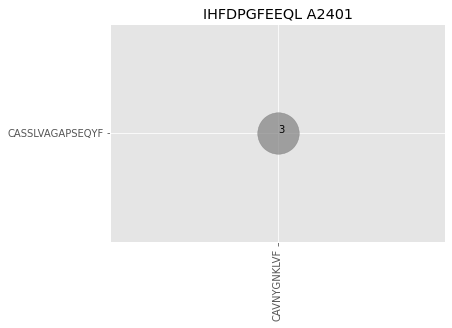

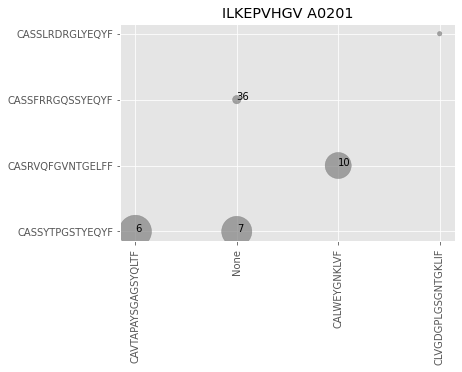

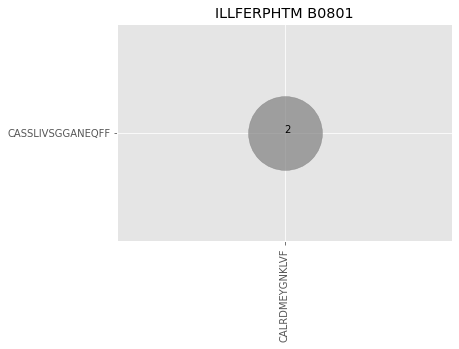

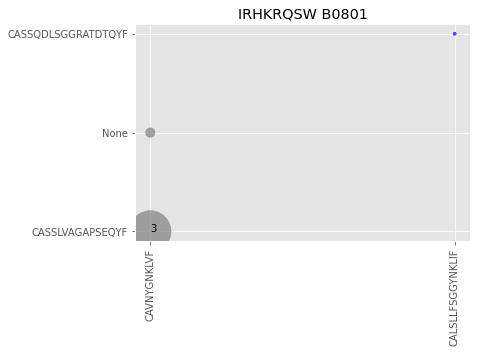

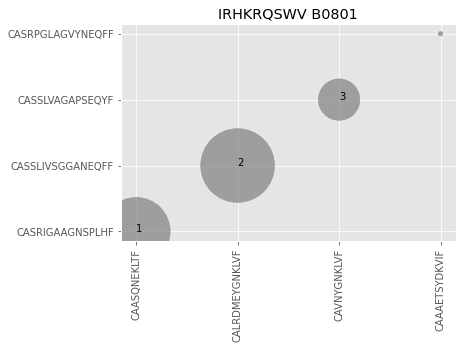

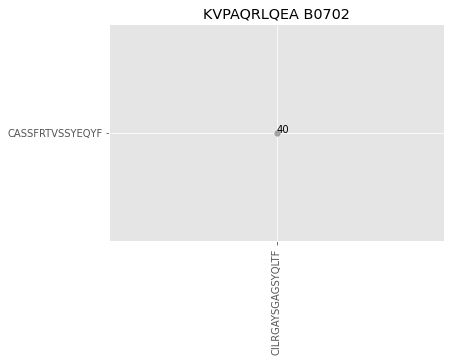

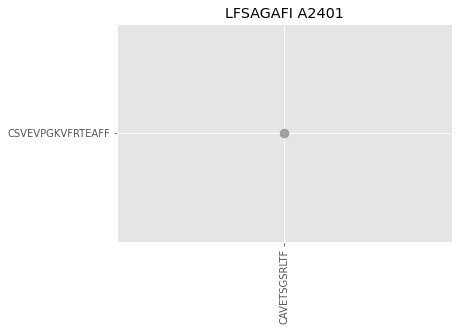

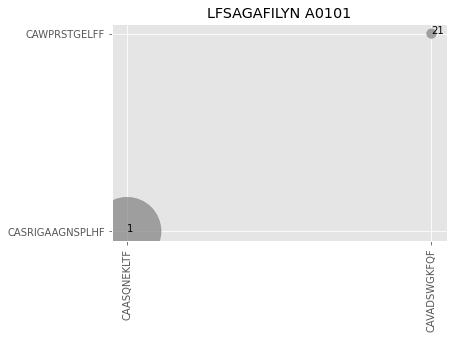

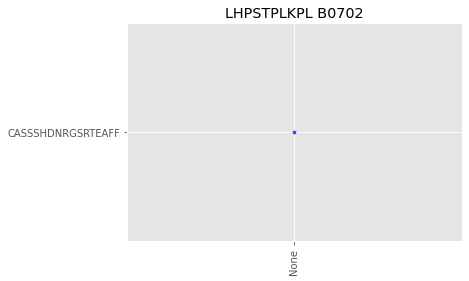

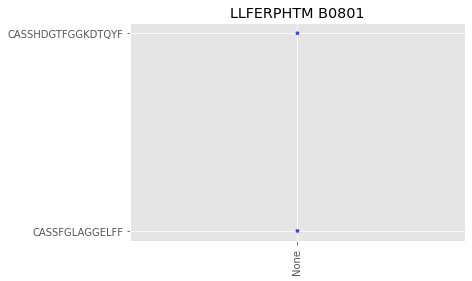

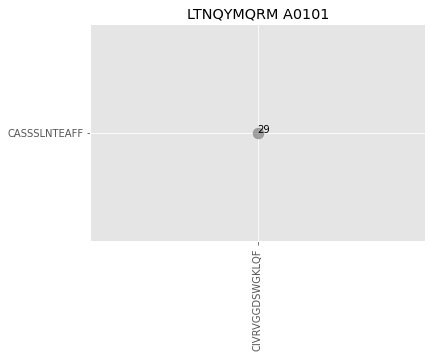

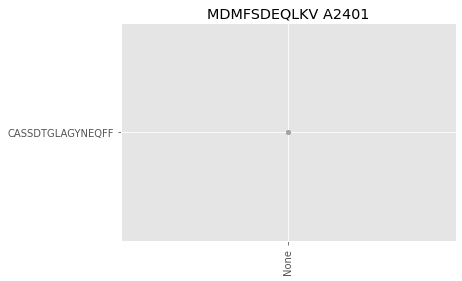

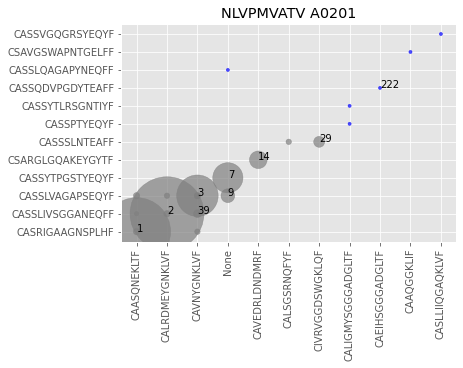

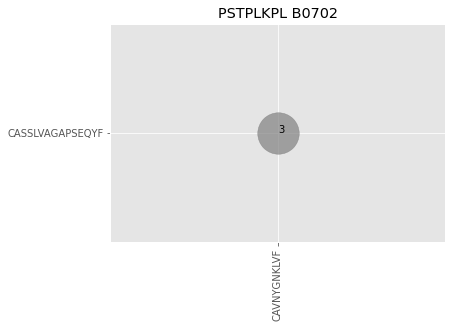

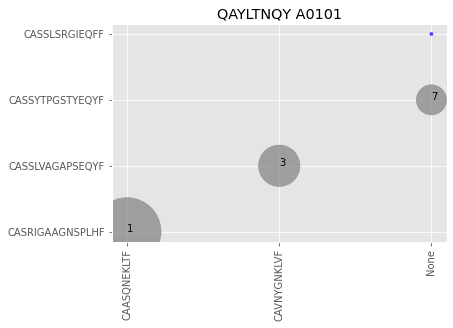

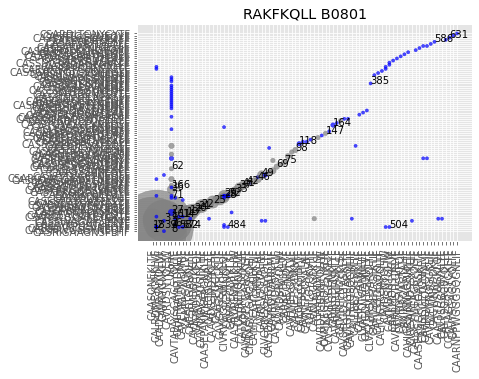

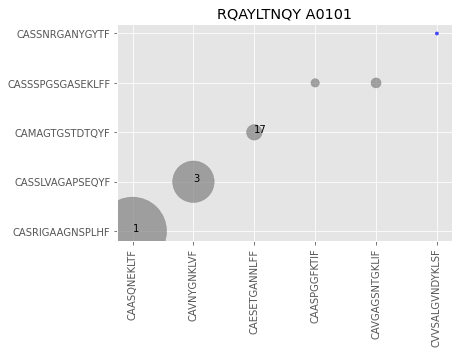

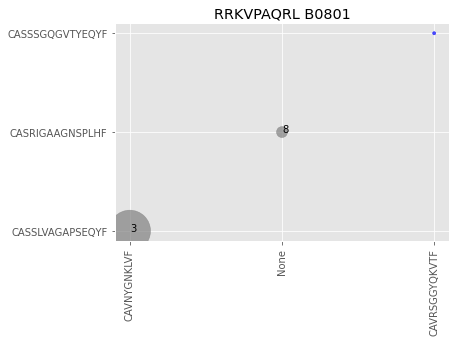

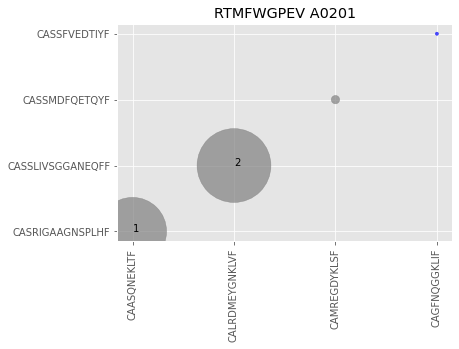

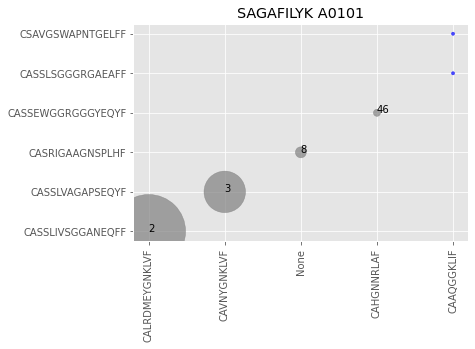

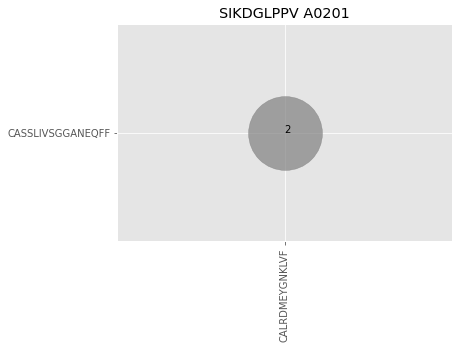

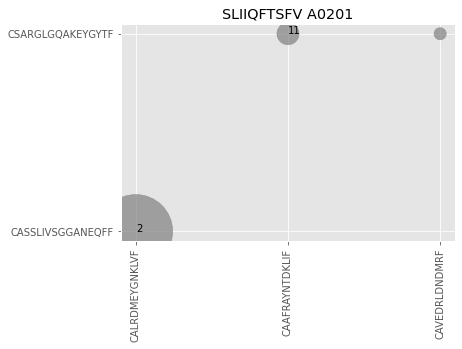

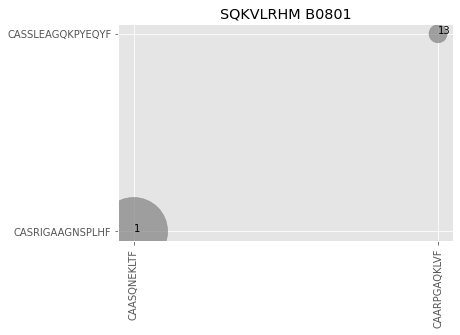

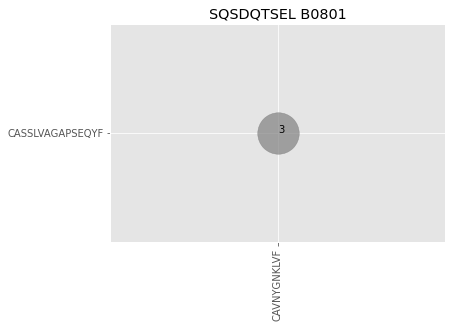

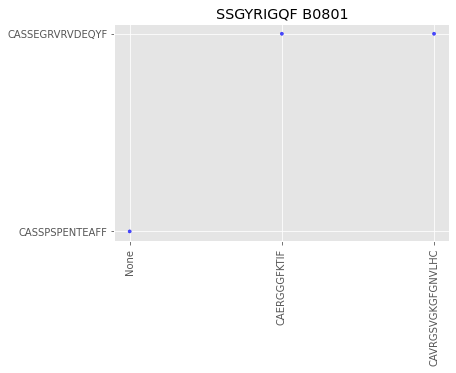

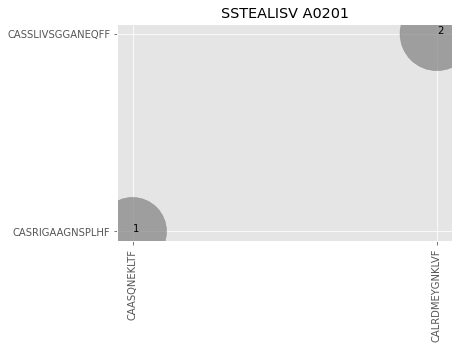

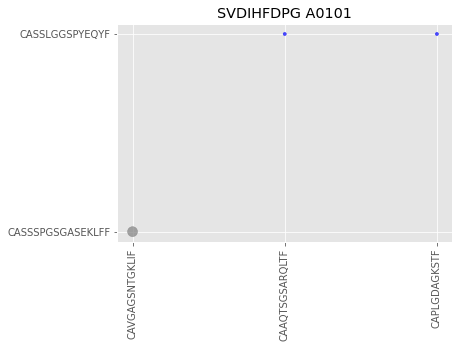

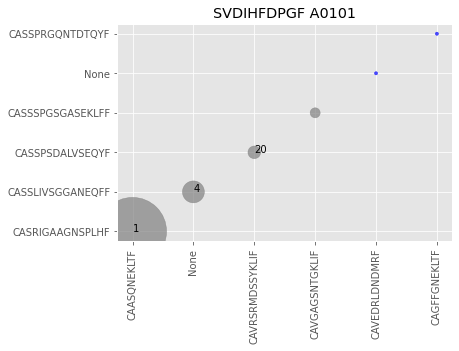

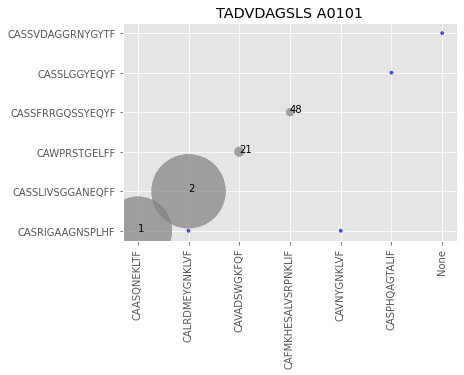

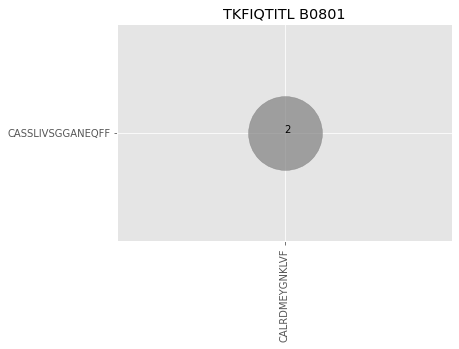

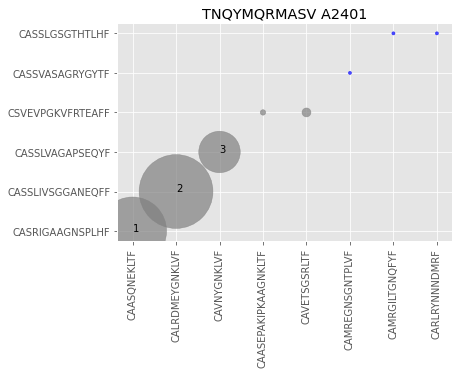

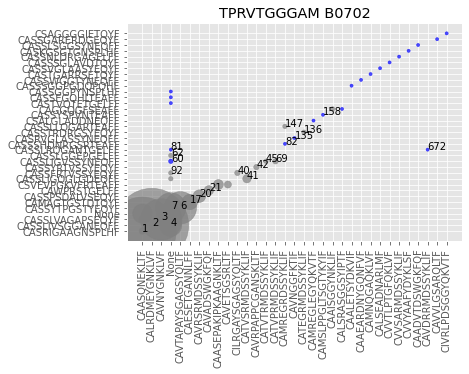

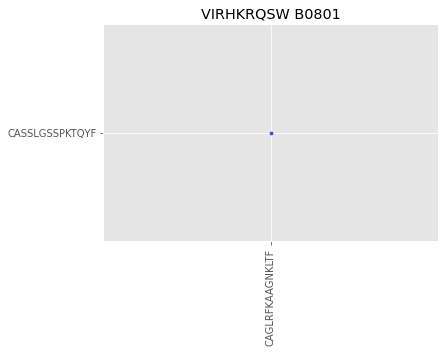

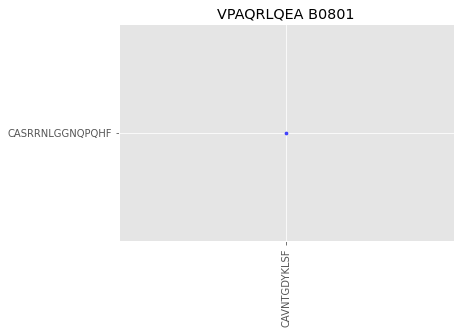

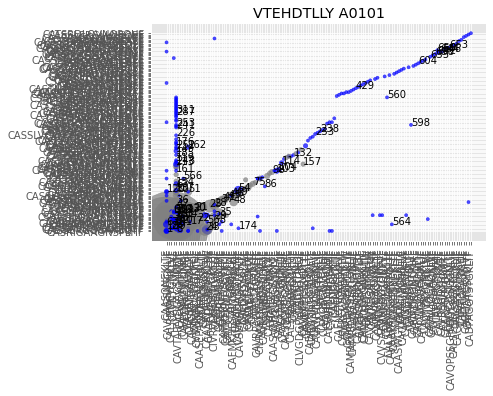

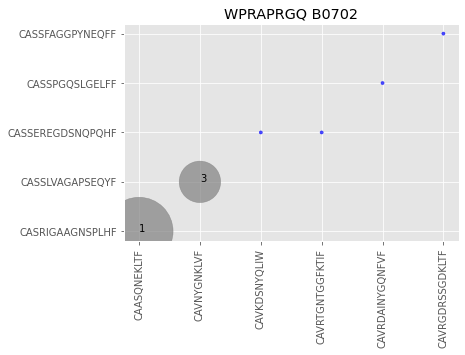

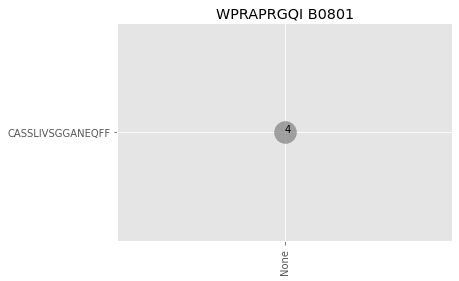

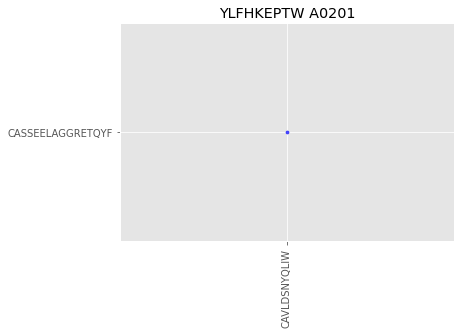

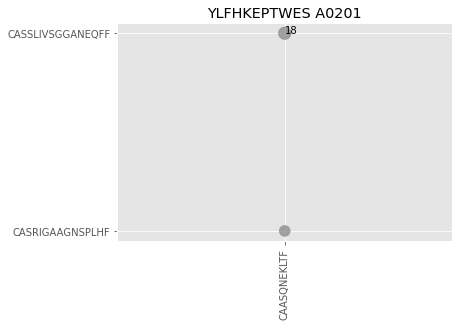

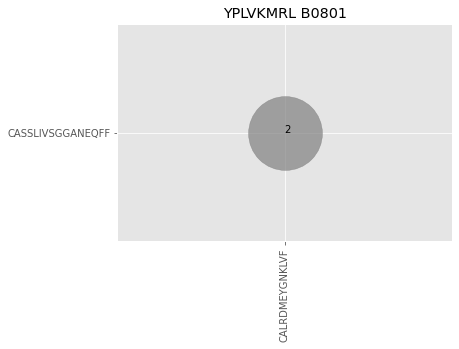

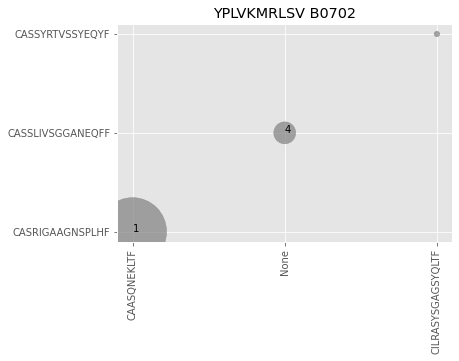

In [68]:
i = 0
for peptide, grp in total_t.explode('peptide_HLA_lst').groupby('peptide_HLA_lst'):
    fig = plt.figure()
    plt.scatter(grp.cdr3_lst_TRA, grp.cdr3_lst_TRB, c=grp.color, s=grp.gem_count*10, alpha=0.7)
    plt.title(peptide)

    ax = plt.gca()
    for ct in grp.ct.astype(int).unique():
        if ct in set(table.ct):
            ax.annotate(str(ct), (table.loc[table.ct == ct, 'cdr3_TRA'], table.loc[table.ct == ct, 'cdr3_TRB']))

    plt.xticks(rotation=90)
    plt.show()
        
    i += 1

In [63]:
grp

,ct,cdr3_lst_TRA,cdr3_lst_TRB,peptide_HLA,peptide_HLA_lst,gem_count,color
33,5.0,CAASQNEKLTF,None,TPRVTGGGAM B0702,"[TPRVTGGGAM B0702, VTEHDTLLY A0101, RAKFKQLL B...",37,grey


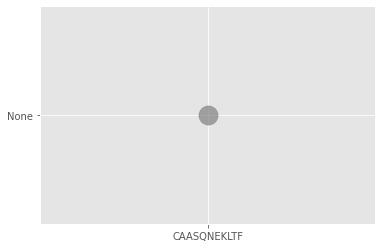

In [64]:
plt.scatter(grp.cdr3_lst_TRA, grp.cdr3_lst_TRB, c=grp.color, s=grp.gem_count*10, alpha=0.7)

### Filtered

In [34]:
table = df[filtering].fillna('None').groupby(['ct','cdr3_TRA','cdr3_TRB']).peptide_HLA.unique().apply(lambda x: x[0]).to_frame()
table['peptide_count'] = df[filtering].fillna('None').groupby(['ct','cdr3_TRA','cdr3_TRB']).gem.count() #.peptide_HLA.size().to_frame()
# what about the CDR3s that are always secondary?

In [35]:
table.reset_index(inplace=True)

In [36]:
colors = ['#d53e4f','#fc8d59','#fee08b','#ffffbf','#e6f598','#99d594','#3288bd']
pep2col = dict(zip(table.peptide_HLA.unique(), colors))

In [37]:
table['color'] = table.peptide_HLA.map(pep2col)

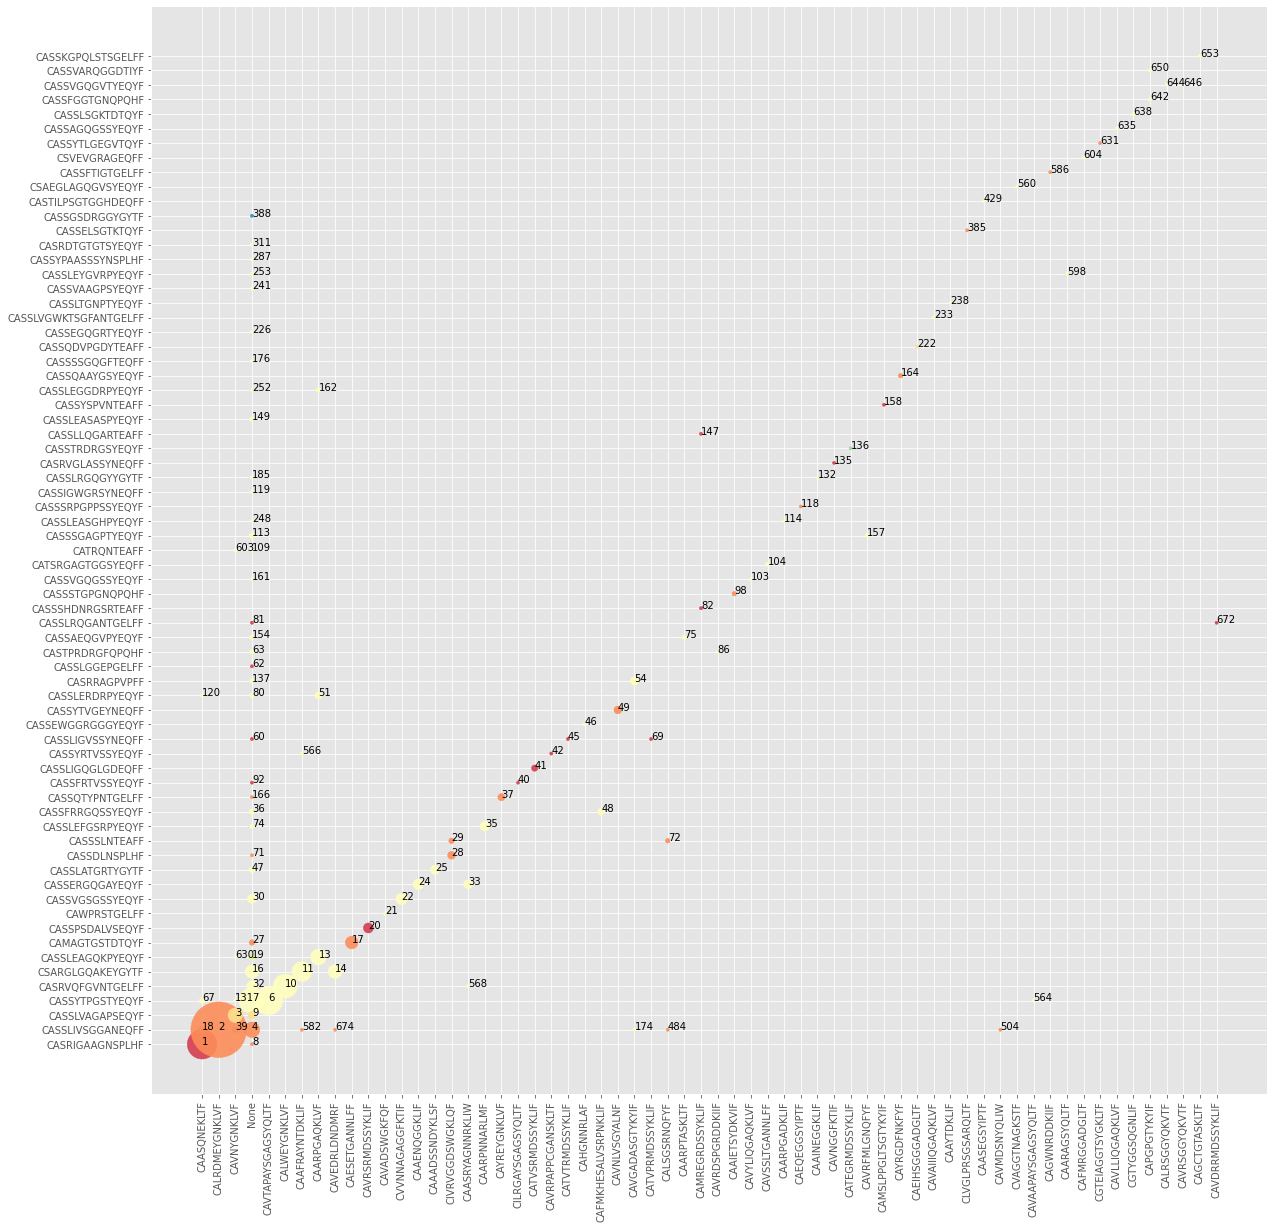

In [38]:
fig = plt.figure(figsize=(20,20))
plt.scatter(table.cdr3_TRA, table.cdr3_TRB, c=table.color, s=table.peptide_count*10, alpha=0.9)


ax = plt.gca()
for i, txt in enumerate(table.ct.astype(int)):
    ax.annotate(txt, (table.cdr3_TRA[i], table.cdr3_TRB[i]))
    
plt.xticks(rotation=90)
plt.savefig('cdr3_duplets.filtered.png')
plt.show()

In [16]:
table.peptide_HLA.unique()

array(['TPRVTGGGAM B0702', 'RAKFKQLL B0801', 'NLVPMVATV A0201',
       'VTEHDTLLY A0101', 'EERQAYLTNQY A0101', 'FSAGAFILYK A0101',
       'ALPGVPPV A0201'], dtype=object)

In [17]:
df[filtering]#.explode('cdr3_lst_TRA').explode('cdr3_lst_TRB')

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr3_TRA,...,likely_HLA_mhc,peptide,peptide_lst,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance
0,AAACCTGAGAGGTAGA-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],509.0,CALRDMEYGNKLVF,...,NaN,RAKFKQLL,['ALPGVPPV' 'RQAYLTNQY' 'VTEHDTLLY' 'EERQAYLTN...,RAKFKQLL B0801,"[ALPGVPPV A0201, RQAYLTNQY A0101, VTEHDTLLY A0...",V17_B8 EBV BZLF1 (C9),['06_1_1' '45_1_49' 'V15_A1 CMV pp50 VTE' '...,390.0,575.0,0.678261
6,AAACCTGTCGAATCCA-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],551.0,CALRDMEYGNKLVF,...,NaN,RAKFKQLL,['TPRVTGGGAM' 'LLFERPHTM' 'HTGEKHYAC' 'FSAGAFI...,RAKFKQLL B0801,"[TPRVTGGGAM B0702, LLFERPHTM B0801, HTGEKHYAC ...",V17_B8 EBV BZLF1 (C9),['V14_B7 CMV pp65 TPR' '47_1_32' '47_1_82' ...,390.0,575.0,0.678261
7,AAACGGGAGGACATTA-1,NaN,0.0,39.0,TRAV3;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC' 'TRAV3;TRAJ47;TRAC'],['TRBV27;;TRBJ2-7;TRBC2' 'TRBV7-3;;TRBJ2-1;TRB...,609.0,CAVNYGNKLVF,...,NaN,RAKFKQLL,['TPRVTGGGAM' 'IRHKRQSWV' 'EERQAYLTNQY' 'MDMFS...,RAKFKQLL B0801,"[TPRVTGGGAM B0702, IRHKRQSWV B0801, EERQAYLTNQ...",V17_B8 EBV BZLF1 (C9),['V14_B7 CMV pp65 TPR' '47_1_94' '45_1_3' '...,NaN,NaN,NaN
11,AAACGGGGTTAGGGTG-1,clonotype2,2.0,2.0,TRAV16;TRAJ47;TRAC,TRBV7-3;;TRBJ2-1;TRBC2,['TRAV16;TRAJ47;TRAC'],['TRBV7-3;;TRBJ2-1;TRBC2'],557.0,CALRDMEYGNKLVF,...,NaN,RAKFKQLL,['VIRHKRQSW' 'SQKVLRHM' 'VTEHDTLLY' 'AMLIRDRL'...,RAKFKQLL B0801,"[VIRHKRQSW B0801, SQKVLRHM B0801, VTEHDTLLY A0...",V17_B8 EBV BZLF1 (C9),['47_1_69' '47_1_90' 'V15_A1 CMV pp50 VTE' ...,390.0,575.0,0.678261
14,AAAGCAAAGCTCTCGG-1,clonotype7,7.0,13.0,TRAV29/DV5;TRAJ54;TRAC,TRBV7-9;;TRBJ2-7;TRBC2,['TRAV29/DV5;TRAJ54;TRAC'],['TRBV7-9;;TRBJ2-7;TRBC2'],508.0,CAARPGAQKLVF,...,NaN,VTEHDTLLY,['ATTADVDAGSL' 'RAKFKQLL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[ATTADVDAGSL A0101, RAKFKQLL B0801, VTEHDTLLY ...",V15_A1 CMV pp50 VTE,['45_1_1' 'V17_B8 EBV BZLF1 (C9)' 'V15_A1 CMV...,30.0,34.0,0.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,TTGCCGTTCCCATTAT-1,clonotype6,6.0,32.0,NaN,TRBV19;;TRBJ2-2;TRBC2,NaN,['TRBV19;;TRBJ2-2;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['FSAGAFILYN' 'ATTADVDAGSL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[FSAGAFILYN A0101, ATTADVDAGSL A0101, VTEHDTLL...",V15_A1 CMV pp50 VTE,['45_1_5' '45_1_1' 'V15_A1 CMV pp50 VTE'],71.0,74.0,0.959459
2423,TTGCGTCAGAGGTAGA-1,clonotype11,11.0,30.0,NaN,TRBV9;;TRBJ2-7;TRBC2,NaN,['TRBV9;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['TNQYMQRMASV' 'NLVPMVATV' 'RAKFKQLL' 'ATTADVD...,VTEHDTLLY A0101,"[TNQYMQRMASV A2401, NLVPMVATV A0201, RAKFKQLL ...",V15_A1 CMV pp50 VTE,['45_1_61' 'V13_A2 CMV pp65 NLV' 'V17_B8 EB...,21.0,24.0,0.875000
2425,TTGCGTCTCTTATCTG-1,clonotype11,11.0,30.0,NaN,TRBV9;;TRBJ2-7;TRBC2,NaN,['TRBV9;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['ATTADVDAGSL' 'VTEHDTLLY'],VTEHDTLLY A0101,"[ATTADVDAGSL A0101, VTEHDTLLY A0101]",V15_A1 CMV pp50 VTE,['45_1_1' 'V15_A1 CMV pp50 VTE'],21.0,24.0,0.875000
2429,TTTCCTCAGCACGCCT-1,clonotype6,6.0,32.0,NaN,TRBV19;;TRBJ2-2;TRBC2,NaN,['TRBV19;;TRBJ2-2;TRBC2'],NaN,NaN,...,NaN,VTEHDTLLY,['RQAYLTNQY' 'ATTADVDAGSL' 'QAYLTNQY' 'RAKFKQL...,VTEHDTLLY A0101,"[RQAYLTNQY A0101, ATTADVDAGSL A0101, QAYLTNQY ...",V15_A1 CMV pp50 VTE,['45_1_49' '45_1_1' '45_1_25' 'V17_B8 EBV BZLF...,71.0,74.0,0.959459


In [18]:
df['tra'] = df.apply(lambda row: list(zip(row.cdr3_lst_TRA, row.umi_count_lst_TRA)), axis=1)
df['trb'] = df.apply(lambda row: list(zip(row.cdr3_lst_TRB, row.umi_count_lst_TRB)), axis=1)

In [20]:
df[df.peptide_HLA == 'TPRVTGGGAM B0702'].explode('tra').explode('trb')

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr3_TRA,...,peptide_lst,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance,tra,trb
15,AAAGCAACAAGCTGAG-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],475.0,CAASQNEKLTF,...,['KVPAQRLQEA' 'AMLIRDRL' 'VTEHDTLLY' 'GPFPGNLV...,TPRVTGGGAM B0702,"[KVPAQRLQEA B0702, AMLIRDRL B0801, VTEHDTLLY A...",V14_B7 CMV pp65 TPR,['47_1_52' '47_1_78' 'V15_A1 CMV pp50 VTE' ...,120.0,496.0,0.241935,"(CAASQNEKLTF, 4)","(CASRIGAAGNSPLHF, 9)"
33,AACCGCGTCTGGAGCC-1,clonotype8,8.0,17.0,TRAV5;TRAJ36;TRAC,TRBV10-3;TRBD1;TRBJ2-3;TRBC2,['TRAV5;TRAJ36;TRAC'],['TRBV10-3;TRBD1;TRBJ2-3;TRBC2'],529.0,CAESETGANNLFF,...,['TPRVTGGGAM'],TPRVTGGGAM B0702,[TPRVTGGGAM B0702],V14_B7 CMV pp65 TPR,['V14_B7 CMV pp65 TPR'],1.0,28.0,0.035714,"(CAESETGANNLFF, 3)","(CAMAGTGSTDTQYF, 6)"
50,AACTCTTAGCGATAGC-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],510.0,CAASQNEKLTF,...,['YPLVKMRLSV' 'GPFPGNLV' 'GPKPAKPCS' 'VTEHDTLL...,TPRVTGGGAM B0702,"[YPLVKMRLSV B0702, GPFPGNLV B0702, GPKPAKPCS B...",V14_B7 CMV pp65 TPR,['47_1_73' '47_1_37' '47_1_40' 'V15_A1 CMV p...,120.0,496.0,0.241935,"(CAASQNEKLTF, 6)","(CASRIGAAGNSPLHF, 4)"
57,AACTGGTCAAGTACCT-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],512.0,CAASQNEKLTF,...,['FSAGAFILYK' 'GPKPAKPCS' 'VTEHDTLLY' 'TPRVTGG...,TPRVTGGGAM B0702,"[FSAGAFILYK A0101, GPKPAKPCS B0702, VTEHDTLLY ...",V14_B7 CMV pp65 TPR,['45_1_4' '47_1_40' 'V15_A1 CMV pp50 VTE' '...,120.0,496.0,0.241935,"(CAASQNEKLTF, 5)","(CASRIGAAGNSPLHF, 5)"
58,AACTGGTCACATGGGA-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],523.0,CAASQNEKLTF,...,['RAKFKQLL' 'KPLFQNDF' 'YPLVKMRLSV' 'GPFPGNLV'...,TPRVTGGGAM B0702,"[RAKFKQLL B0801, KPLFQNDF B0702, YPLVKMRLSV B0...",V14_B7 CMV pp65 TPR,['V17_B8 EBV BZLF1 (C9)' '47_1_49' '47_1_73' '...,120.0,496.0,0.241935,"(CAASQNEKLTF, 8)","(CASRIGAAGNSPLHF, 9)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,GATGAGGCACATAACC-1,clonotype205,205.0,378.0,NaN,TRBV19;;TRBJ1-6;TRBC1,NaN,['TRBV19;;TRBJ1-6;TRBC1'],NaN,NaN,...,['TPRVTGGGAM'],TPRVTGGGAM B0702,[TPRVTGGGAM B0702],V14_B7 CMV pp65 TPR,['V14_B7 CMV pp65 TPR'],1.0,1.0,1.000000,NaN,"(CASSGGPYNSPLHF, 2)"
2297,GCTCTGTTCACCTTAT-1,clonotype2,2.0,4.0,NaN,TRBV7-3;;TRBJ2-1;TRBC2,NaN,['TRBV7-3;;TRBJ2-1;TRBC2'],NaN,NaN,...,['TPRVTGGGAM'],TPRVTGGGAM B0702,[TPRVTGGGAM B0702],V14_B7 CMV pp65 TPR,['V14_B7 CMV pp65 TPR'],10.0,575.0,0.017391,NaN,"(CASSLIVSGGANEQFF, 3)"
2300,GCTTCCAGTTACTGAC-1,clonotype98,98.0,60.0,NaN,TRBV7-9;;TRBJ2-1;TRBC2,NaN,['TRBV7-9;;TRBJ2-1;TRBC2'],NaN,NaN,...,['VTEHDTLLY' 'GPKPAKPCS' 'KPLFQNDF' 'RAKFKQLL'...,TPRVTGGGAM B0702,"[VTEHDTLLY A0101, GPKPAKPCS B0702, KPLFQNDF B0...",V14_B7 CMV pp65 TPR,['V15_A1 CMV pp50 VTE' '47_1_40' '47_1_49' ...,1.0,1.0,1.000000,NaN,"(CASSLIGVSSYNEQFF, 14)"
2311,GGCTCGATCTCTAGGA-1,clonotype461,461.0,38.0,NaN,TRBV7-9;;TRBJ2-1;TRBC2,NaN,['TRBV7-9;;TRBJ2-1;TRBC2'],NaN,NaN,...,['TPRVTGGGAM'],TPRVTGGGAM B0702,[TPRVTGGGAM B0702],V14_B7 CMV pp65 TPR,['V14_B7 CMV pp65 TPR'],1.0,1.0,1.000000,NaN,"(CASSLIGQGLGDEQFF, 4)"


In [ ]:
df['ct_pep'] = np.nan
trash_bin = set()
value_bin =set()
selected_clonotypes = df.groupby('peptide_HLA').size().sort_values(ascending=False)#.head(10)
all_tra = df.cdr3_lst_TRA.explode()

for peptide in df.peptide_HLA.sort_values().unique(): #selected_clonotypes.index:
    mat_tra = pd.DataFrame(index=all_tra.unique(), columns=df.gem.unique())
    mat_trb = pd.DataFrame(index=all_tra.unique(), columns=df.gem.unique())
    df[df.peptide_HLA == peptide].apply(lambda row: sum_umi_tra(row), axis=1)
    df[df.peptide_HLA == peptide].apply(lambda row: sum_umi_trb(row), axis=1)
    
    #summary df
    summary_tra = mat_tra.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
    summary_tra['avg'] = mat_tra.mean(axis=1)
    summary_tra['col'] = 'grey'
    summary_trb = mat_trb.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
    summary_trb['avg'] = mat_trb.mean(axis=1)
    summary_trb['col'] = 'grey'
    
    summed_umis = summary_tra.s.head(10)
    summed_gems = (mat > 0).sum(axis=1)
    annotated_gems = df[df.ct == ct].groupby('peptide_HLA').size()
    all_gems_hla = pd.concat([annotated_gems,
                              pd.Series(0, index=all_peptide_HLA[~all_peptide_HLA.isin(annotated_gems.index)].unique())])
    
    # test if two annotations are significantly different distributed.
    if test_dist():
        # Maybe accumulate distributions for true imputations to compare with when in doubt?
        df.loc[df.ct == ct, 'ct_pep'] = summary_df.index[0]
        value_bin.update([ct])
        trash_bin.update(summary_df.index[1:10])
        figure_flag = 'significant'
        #if ct > 10:
        #    continue
    else:
        if summary_df.index[0] not in trash_bin:
            if summary_df.index[1] not in trash_bin:
                print('HELP!')
                figure_flag = 'insignificant'
            else:
                df.loc[df.ct == ct, 'ct_pep'] = summary_df.index[0]
                trash_bin.update(summary_df.index[1:10])
                print(ct, 'resolved by trash bin')
                figure_flag = 'insignificant'
        else:
            # Highlight the clonotypes that are ambiguous
            if len(df[(df.ct == ct) & (df.tcr_category.isin(['multiple chains']))]) > 0:
                df.loc[df.ct == ct, 'ct_pep'] = 'unsolvable'
                print('unsolvable!')
                figure_flag = 'insignificant'
            else:
                # Check if distribution matches a previously accepted peptide distribution.
                df.loc[df.ct == ct, 'ct_pep'] = 'unresolved'
                print(ct, 'unresolved')
                figure_flag = 'insignificant'
            
        #print(df.loc[df.ct ==ct, ['peptide', 'peptide_lst','umi_count_lst_mhc',
        #                          'cdr3_lst_TRA','genes_lst_TRA','umi_count_lst_TRA',
        #                          'cdr3_lst_TRB','genes_lst_TRB','umi_count_lst_TRB']])
    # Highlight the clonotypes that are ambiguous
    if len(df[(df.ct == ct) & (df.tcr_category.isin(['multiple chains']))]) > 0:
        print('Multiple TCR chains - in theory unsolvable!')
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
    # Histogram
    for peptide_HLA in summed_umis.index:
        ax2.hist(mat.T[peptide_HLA].dropna(), alpha=0.2, label='%s %s %d (%d) (%d)' %(peptide_HLA.split(' ')[1], peptide_HLA.split(' ')[0], summed_umis[peptide_HLA], summed_gems[peptide_HLA], all_gems_hla[peptide_HLA]))
    summary_df.iloc[0:10, summary_df.columns.to_list().index('col')] = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Boxplot
    boxes = list()
    meaned_umis = summary_df.sort_values(by='avg',ascending=False).head(10)
    for peptide_HLA in meaned_umis.index:
        boxes.append(mat.T[peptide_HLA].dropna().to_list())
    bp = ax1.boxplot(boxes, patch_artist=True) #, vert=False
    colors = meaned_umis.col #.to_list()
    
    # whiskers and caps have to be treated separately since there are two of each for each plot
    for item in ['whiskers', 'caps']:
        for sub_item, color in zip(zip(bp[item][::2], bp[item][1::2]), colors):
            plt.setp(sub_item, color=color, alpha=0.2)
    for item in ['fliers']:
        for sub_item, color in zip(bp[item], colors):
            plt.setp(sub_item, markeredgecolor=color, alpha=0.2)
    for item in ['boxes', 'medians']:
        for sub_item, color in zip(bp[item], colors):
            plt.setp(sub_item, color=color, alpha=0.2)
            
    ax1.set_title('Sorted by mean of BC UMI')
    ax1.set_xticklabels(meaned_umis.index, rotation=90)
    ax1.set_ylabel('UMI count')
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    ax1.set_axisbelow(True) # Hide these grid behind plot objects
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='HLA peptide UMI-sum (found in #GEMs) (ann. in #GEMs)')
    ax2.set_xlabel('UMI count')
    ax2.set_ylabel('GEM count')
    ax2.set_title('Clonotype %d (%d GEMs)\n%s - %s\n%s - %s' %(ct, selected_clonotypes[ct],
                                               df[df.ct == ct].genes_TRA.unique()[0], df[df.ct == ct].cdr3_TRA.unique()[0],
                                               df[df.ct == ct].genes_TRB.unique()[0], df[df.ct == ct].cdr3_TRB.unique()[0]))
    #if ct == 222:
    #    plt.savefig('%s.pdf'%ct)
    #    print(summed_umis)
    #    print(summed_gems)
    #    print(all_gems_hla)
    #plt.show()
    
    plt.savefig(PLT + figure_flag + '/%s.pdf' %ct, bbox_inches='tight')
    
    plt.figure(figsize=(5,3))
    delta = df.loc[df.ct == ct, ['delta_umi_mhc','peptide_HLA']].sort_values('delta_umi_mhc', ascending=False).groupby('peptide_HLA', sort=False).delta_umi_mhc.apply(list)
    plt.boxplot(delta.to_list()[:10])
    plt.xticks(np.arange(1, min(11, len(delta)+1)), delta.index[:10], rotation=90)
    plt.show()
    

